#  Deep Convolutional Generative Adversarial Network

* The architecture is comprised of two networks: a generator and a discriminator.

  -  **Generator**: This network aims to create realistic data by generating samples from random noise. It takes random noise as input and generates data that ideally resembles the training data.

  -  **Discriminator**: The discriminator, on the other hand, tries to distinguish between real data (from the training set) and fake data created by the generator. It's trained to correctly classify the input as either real or fake.

The two networks are **trained simultaneously** in a competitive process. The generator aims to create increasingly realistic data to fool the discriminator, while the discriminator aims to become more accurate in distinguishing real from fake data. Through this adversarial process, both networks improve until the generator creates data that is indistinguishable from real data.

DCGANs have been successful in generating realistic images, such as human faces or objects, and have applications in image generation, data augmentation, and other domains requiring the generation of synthetic data.

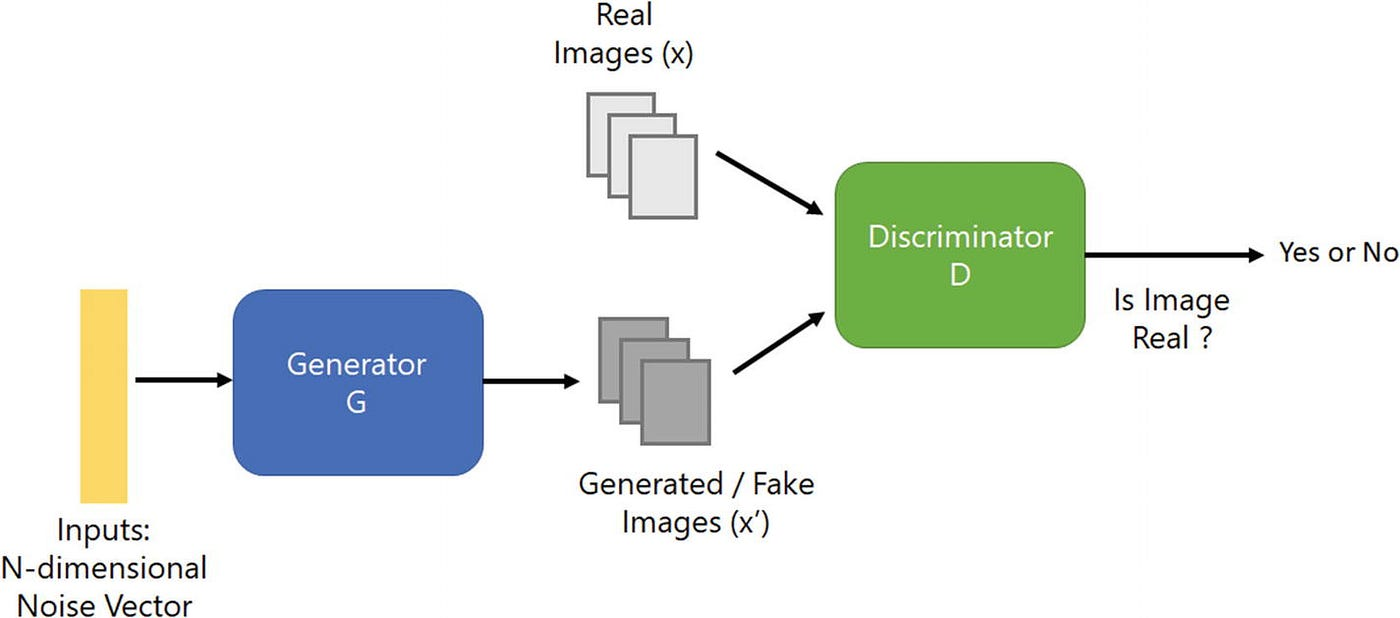

# setup my Environment 

In [1]:
PATH='/kaggle/input/braille-character-dataset/Braille Dataset/Braille Dataset'
save_path='/kaggle/working/best_generator.h5'

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
#
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
#
import os
from tqdm import tqdm
#
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense ,Conv2DTranspose ,Conv2D ,Flatten,Reshape ,BatchNormalization, MaxPool2D,LeakyReLU ,Dropout
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Functions

### For Reading Data

In [3]:
class cCreateData_Gan:

    def __init__(self,path) -> None:
       self.path = path
    #
    def CreateDataFrame_Gan(self):
        '''Create DataFream contain Full Path of Images '''
        arrData=[]
        for imgfile in tqdm(os.listdir(self.path)):
            imgPath = os.path.join(self.path,imgfile)
            arrData.append(imgPath)
        return pd.DataFrame(arrData,columns=['Path'])

    def ReadImgs_Gan(self,W=28,H=28,C=1):
        df=self.CreateDataFrame_Gan()
        arrImg=[]
        for i in df['Path']:
            img=cv2.imread(i)
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = img.flatten()  # Flatten the image to 1D
            arrImg.append(img)

        x_train = np.array(arrImg)
        x_train = x_train.reshape(x_train.shape[0], W, H, C).astype('float32')
        x_train = (x_train -127.5) / 127.5  # Normalize images to the range [-1,1]
        return x_train

    def DataSet_Slices_Batch(self,buffer_size=512,batch_size=128,W=28,H=28,C=1):
      ''' Call Only This Function To Create Your Data '''
      x_train=self.ReadImgs_Gan(W,H,C)
      dataset = tf.data.Dataset.from_tensor_slices(x_train)
      dataset = dataset.shuffle(buffer_size=buffer_size).batch(batch_size)
      return dataset


# create Obj
objCreateData=cCreateData_Gan(PATH)

### For Display Plots

In [4]:
def display_20SampleImages(dataset):
  plt.figure(figsize=(20, 10))
  for i in range(dataset.shape[0]):
    plt.subplot(4, 5, i+1)
    plt.imshow(dataset[i, :, :, 0], cmap='gray')
    plt.axis('off')
  plt.tight_layout()
  plt.show()

### For Deep Convolutional GAN **(DCGAN)**

In [5]:
class cDCGAN:
  def __init__(self,latent_dim=100,batch_size=128,lr=0.0001) :
    self.latent_dim=latent_dim
    self.batch_size=batch_size
    # build empty Netwok
    self.generator = Sequential()
    self.discriminator = Sequential()
    #
    self.cross_entropy = BinaryCrossentropy(from_logits=True)
    #
    self.generator_optimizer = Adam(lr)
    self.discriminator_optimizer = Adam(lr)
    # lists history
    self.gen_hist=[]
    self.disc_hist=[]
    self.disc_hist_total=[]


  def build_generator_model(self):
    '''' Build Deep Convolutional Network to generate new images (28,28,1) '''
    # input = latent_dim
    self.generator.add(Dense(7*7*256,use_bias=False,input_shape=(self.latent_dim,)))
    self.generator.add( BatchNormalization())
    self.generator.add(LeakyReLU())
    # output = 7*7*256 = 12544

    # Convert 12544 (1D) to (7,7,256) (3D)
    self.generator.add(Reshape((7, 7, 256)))
    assert self.generator.output_shape == (None, 7, 7, 256) # (batchSize,W,H,F)

    # input (7,7,256)
    self.generator.add(Conv2DTranspose(128,(5,5),strides=(1,1) ,padding='same',use_bias=False))
    assert self.generator.output_shape == (None, 7, 7, 128)
    self.generator.add( BatchNormalization())
    self.generator.add(LeakyReLU())

    # input (7,7,128)
    self.generator.add(Conv2DTranspose(64,(5,5),strides=(2,2) ,padding='same',use_bias=False))
    assert self.generator.output_shape == (None, 14, 14, 64)
    self.generator.add( BatchNormalization())
    self.generator.add(LeakyReLU())

    # input(14,14,64)
    self.generator.add(Conv2DTranspose(32,(5,5),strides=(2,2) ,padding='same',use_bias=False))
    assert self.generator.output_shape == (None, 28, 28,32)
    self.generator.add( BatchNormalization())
    self.generator.add(LeakyReLU())

    # input(28,28,32)
    self.generator.add(Conv2DTranspose(1,(5,5),strides=(1,1) ,padding='same', use_bias=False, activation='tanh'))
    assert self.generator.output_shape == (None, 28, 28, 1)

    # output(28,28,1)

    return self.generator


  def build_discriminator_model(self):
    '''Build Deep Convolutional Network to classification real image or generated  '''
    # input img (28*28*1)

    # Layer Conv 1
    self.discriminator.add(Conv2D(64,(3,3), padding='same',input_shape=[28, 28, 1]))
    self.discriminator.add( BatchNormalization())
    self.discriminator.add(MaxPool2D(2))
    self.discriminator.add(LeakyReLU())
    self.discriminator.add(Dropout(0.3))
    # Layer Conv 2
    self.discriminator.add(Conv2D(32,(3,3)))
    self.discriminator.add( BatchNormalization())
    self.discriminator.add(MaxPool2D(2))
    self.discriminator.add(LeakyReLU())
    self.discriminator.add(Dropout(0.3))
    # Layer Conv 3
    self.discriminator.add(Conv2D(16,(3,3)))
    self.discriminator.add( BatchNormalization())
    self.discriminator.add(MaxPool2D(2))
    self.discriminator.add(LeakyReLU())
    self.discriminator.add(Dropout(0.3))

    self.discriminator.add(Flatten())

    self.discriminator.add(Dense(128))
    self.discriminator.add(LeakyReLU())
    self.discriminator.add(Dropout(0.2))
    self.discriminator.add(Dense(1,activation='sigmoid'))
    # output (Real || Fake)

    return self.discriminator


  def generator_loss(self, fake_output):
    return self.cross_entropy(tf.ones_like(fake_output), fake_output)

  def discriminator_loss(self,real_output, fake_output):
    real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss =self.cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss , fake_loss


  def train_process(self,images):
    ''' Calculate Gradient and Update Wights'''
    # Generating noise from a normal distribution
    fake_img_noise = tf.random.normal([self.batch_size, self.latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images =self. generator(fake_img_noise, training=True)

      real_output = self.discriminator(images, training=True)
      fake_output = self.discriminator(generated_images, training=True)

      gen_loss = self.generator_loss(fake_output)
      real_loss_dis,fake_loss_dis = self.discriminator_loss(real_output, fake_output)
      disc_loss =real_loss_dis+fake_loss_dis

      gradients_of_generator = gen_tape.gradient(gen_loss,self.generator.trainable_variables)
      self.generator_optimizer.apply_gradients(zip(gradients_of_generator,self.generator.trainable_variables))

      gradients_of_discriminator = disc_tape.gradient(disc_loss,self.discriminator.trainable_variables)
      self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,self.discriminator.trainable_variables))

      self.gen_hist.append(gen_loss)
      self.disc_hist.append([real_loss_dis,fake_loss_dis])
      self.gen_hist.append(disc_loss)

  def Fit_GAN(self, dataset, epochs, save_path='best_generator.h5'):
      # build models
      self.generator = self.build_generator_model()
      self.discriminator = self.build_discriminator_model()
      # compile
      self.generator.compile(optimizer=self.generator_optimizer, loss=self.generator_loss)
      self.discriminator.compile(optimizer=self.discriminator_optimizer, loss=self.discriminator_loss)


      best_loss = float('inf')  # Initialize with a very high loss
      for epoch in tqdm(range(epochs)):
          for batch in dataset:
              self.train_process(batch)

          # Calculate generator loss at the end of each epoch
          avg_gen_loss = tf.reduce_mean(self.gen_hist)

          # Save the generator model if the current loss is the best observed so far
          if avg_gen_loss < best_loss:
              best_loss = avg_gen_loss
              self.generator.save(save_path)  # Save the best model
              print(f'saved {avg_gen_loss.numpy()}')

          print(f"Epoch {epoch + 1}/{epochs}, Generator Loss: {avg_gen_loss.numpy()}")
          print('==='*20)

      print("Training completed.")

# Start 


## Read Data

In [ ]:
buffer_size=512
batch_size=128

In [7]:
dataset = objCreateData.DataSet_Slices_Batch(batch_size=batch_size,buffer_size=buffer_size)

100%|██████████| 1560/1560 [00:00<00:00, 378499.12it/s]


### Dispaly Sample from Data

100%|██████████| 1560/1560 [00:00<00:00, 326144.66it/s]


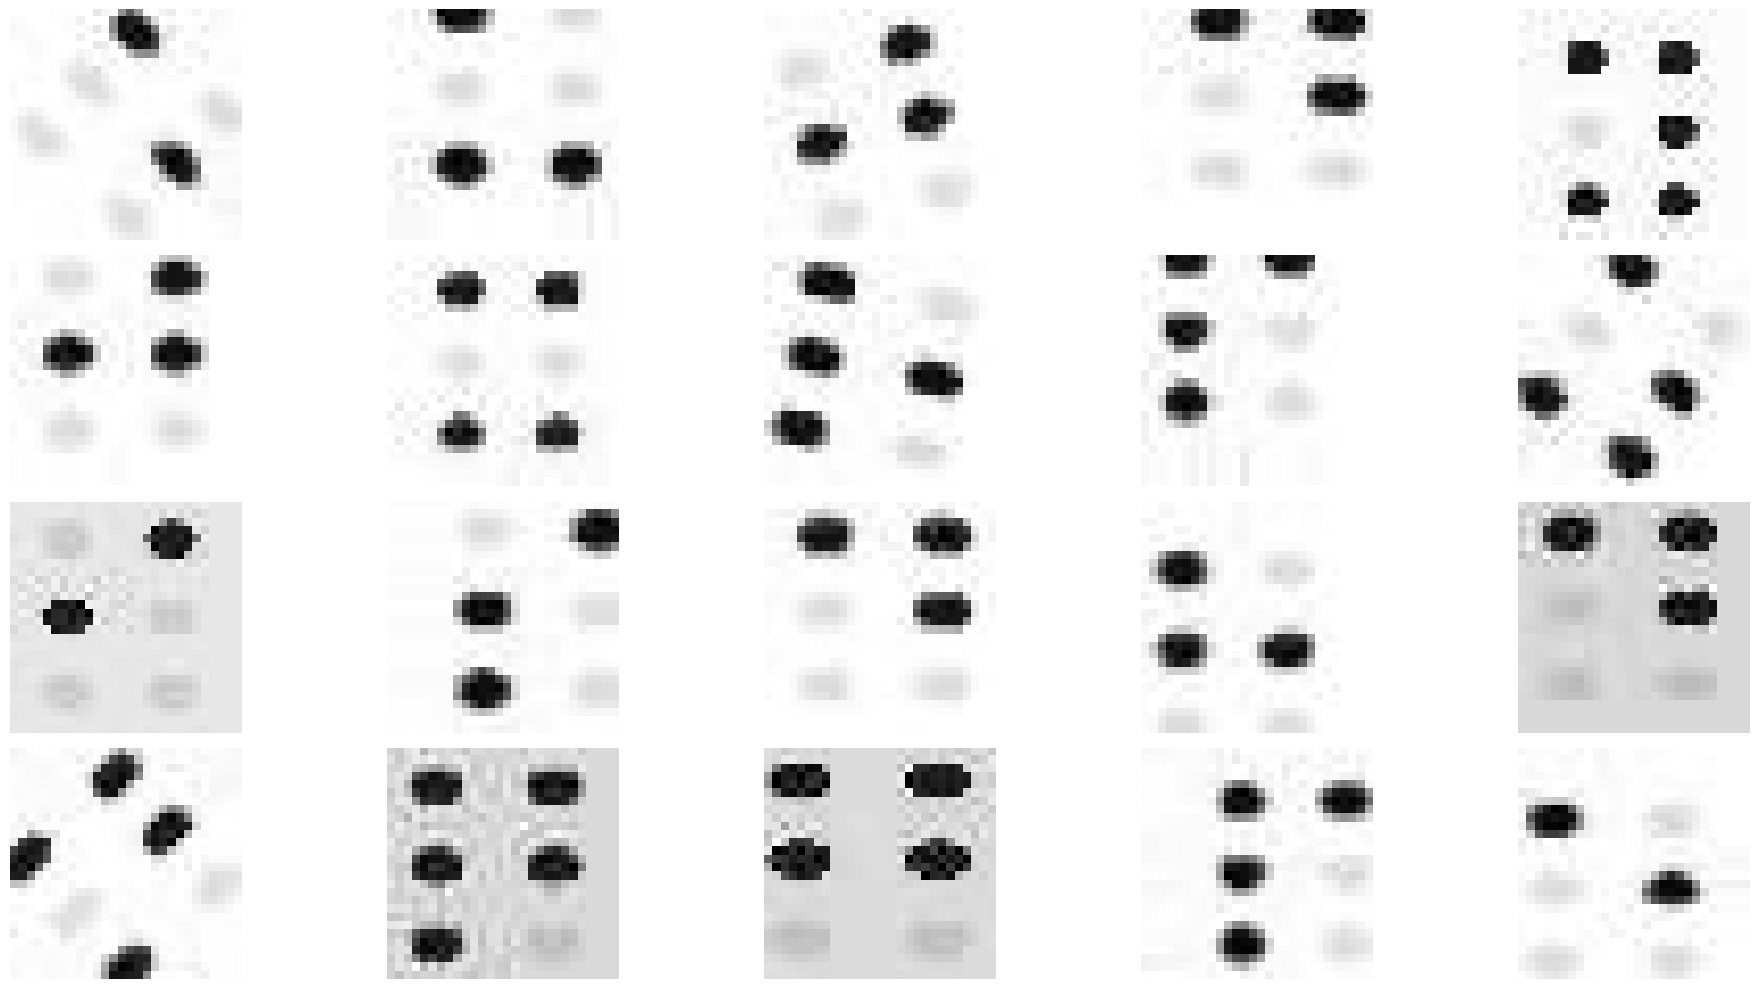

In [8]:
X_train = objCreateData.ReadImgs_Gan()

display_20SampleImages(X_train[:20])

## Build & Train **DCGAN**

### 1.Set variables

In [ ]:
latent_dim=100 # noise
epochs=700
lr=0.000097

### 2.Create Obiect from cDCGAN


In [10]:
objDCGAN= cDCGAN(batch_size=batch_size,latent_dim=latent_dim,lr=lr)

### 3.Train Models  

In [11]:
objDCGAN.Fit_GAN(dataset,epochs,save_path)

  0%|          | 0/700 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
  0%|          | 1/700 [00:19<3:51:28, 19.87s/it]

saved 1.1554713249206543
Epoch 1/700, Generator Loss: 1.1554713249206543


  0%|          | 2/700 [00:21<1:47:41,  9.26s/it]

Epoch 2/700, Generator Loss: 1.1561882495880127


  0%|          | 3/700 [00:23<1:08:29,  5.90s/it]

Epoch 3/700, Generator Loss: 1.1676801443099976


  1%|          | 4/700 [00:25<50:17,  4.34s/it]  

Epoch 4/700, Generator Loss: 1.1781456470489502


  1%|          | 5/700 [00:27<40:32,  3.50s/it]

Epoch 5/700, Generator Loss: 1.1866711378097534


  1%|          | 6/700 [00:29<35:37,  3.08s/it]

Epoch 6/700, Generator Loss: 1.1953542232513428


  1%|          | 7/700 [00:32<32:31,  2.82s/it]

Epoch 7/700, Generator Loss: 1.2027196884155273


  1%|          | 8/700 [00:34<30:33,  2.65s/it]

Epoch 8/700, Generator Loss: 1.1973459720611572


  1%|▏         | 9/700 [00:36<29:10,  2.53s/it]

Epoch 9/700, Generator Loss: 1.1932872533798218


  1%|▏         | 10/700 [00:38<28:16,  2.46s/it]

Epoch 10/700, Generator Loss: 1.1888495683670044


  2%|▏         | 11/700 [00:41<27:42,  2.41s/it]

Epoch 11/700, Generator Loss: 1.1845180988311768


  2%|▏         | 12/700 [00:43<27:26,  2.39s/it]

Epoch 12/700, Generator Loss: 1.1788403987884521


  2%|▏         | 13/700 [00:46<27:47,  2.43s/it]

Epoch 13/700, Generator Loss: 1.1755552291870117


  2%|▏         | 14/700 [00:48<26:34,  2.32s/it]

Epoch 14/700, Generator Loss: 1.1750009059906006


  2%|▏         | 15/700 [00:50<25:21,  2.22s/it]

Epoch 15/700, Generator Loss: 1.1756105422973633


  2%|▏         | 16/700 [00:52<24:27,  2.14s/it]

Epoch 16/700, Generator Loss: 1.1759064197540283


  2%|▏         | 17/700 [00:54<24:12,  2.13s/it]

Epoch 17/700, Generator Loss: 1.1734176874160767


  3%|▎         | 18/700 [00:56<23:48,  2.10s/it]

Epoch 18/700, Generator Loss: 1.1717637777328491


  3%|▎         | 19/700 [00:58<23:23,  2.06s/it]

Epoch 19/700, Generator Loss: 1.16951584815979


  3%|▎         | 20/700 [01:00<23:01,  2.03s/it]

Epoch 20/700, Generator Loss: 1.1685073375701904


  3%|▎         | 21/700 [01:02<22:44,  2.01s/it]

Epoch 21/700, Generator Loss: 1.1679621934890747


  3%|▎         | 22/700 [01:04<22:37,  2.00s/it]

Epoch 22/700, Generator Loss: 1.1641110181808472


  3%|▎         | 23/700 [01:06<22:38,  2.01s/it]

Epoch 23/700, Generator Loss: 1.1586371660232544


  3%|▎         | 24/700 [01:08<23:40,  2.10s/it]

saved 1.1543822288513184
Epoch 24/700, Generator Loss: 1.1543822288513184


  4%|▎         | 25/700 [01:10<24:43,  2.20s/it]

saved 1.1528109312057495
Epoch 25/700, Generator Loss: 1.1528109312057495


  4%|▎         | 26/700 [01:13<24:59,  2.23s/it]

Epoch 26/700, Generator Loss: 1.1531902551651


  4%|▍         | 27/700 [01:15<25:14,  2.25s/it]

Epoch 27/700, Generator Loss: 1.153359055519104


  4%|▍         | 28/700 [01:17<25:21,  2.26s/it]

Epoch 28/700, Generator Loss: 1.1531659364700317


  4%|▍         | 29/700 [01:20<25:34,  2.29s/it]

saved 1.1523438692092896
Epoch 29/700, Generator Loss: 1.1523438692092896


  4%|▍         | 30/700 [01:22<26:04,  2.34s/it]

saved 1.1488661766052246
Epoch 30/700, Generator Loss: 1.1488661766052246


  4%|▍         | 31/700 [01:25<26:25,  2.37s/it]

saved 1.1443603038787842
Epoch 31/700, Generator Loss: 1.1443603038787842


  5%|▍         | 32/700 [01:27<25:53,  2.33s/it]

saved 1.1417064666748047
Epoch 32/700, Generator Loss: 1.1417064666748047


  5%|▍         | 33/700 [01:29<24:53,  2.24s/it]

saved 1.1410669088363647
Epoch 33/700, Generator Loss: 1.1410669088363647


  5%|▍         | 34/700 [01:31<23:51,  2.15s/it]

Epoch 34/700, Generator Loss: 1.1418437957763672


  5%|▌         | 35/700 [01:33<23:08,  2.09s/it]

Epoch 35/700, Generator Loss: 1.1425014734268188


  5%|▌         | 36/700 [01:35<22:38,  2.05s/it]

Epoch 36/700, Generator Loss: 1.142455816268921


  5%|▌         | 37/700 [01:37<22:26,  2.03s/it]

Epoch 37/700, Generator Loss: 1.141674280166626


  5%|▌         | 38/700 [01:39<22:29,  2.04s/it]

saved 1.1408054828643799
Epoch 38/700, Generator Loss: 1.1408054828643799


  6%|▌         | 39/700 [01:41<22:28,  2.04s/it]

saved 1.1402921676635742
Epoch 39/700, Generator Loss: 1.1402921676635742


  6%|▌         | 40/700 [01:43<22:23,  2.04s/it]

saved 1.1400423049926758
Epoch 40/700, Generator Loss: 1.1400423049926758


  6%|▌         | 41/700 [01:45<22:23,  2.04s/it]

saved 1.139251947402954
Epoch 41/700, Generator Loss: 1.139251947402954


  6%|▌         | 42/700 [01:47<23:02,  2.10s/it]

saved 1.1380614042282104
Epoch 42/700, Generator Loss: 1.1380614042282104


  6%|▌         | 43/700 [01:49<23:54,  2.18s/it]

saved 1.1369256973266602
Epoch 43/700, Generator Loss: 1.1369256973266602


  6%|▋         | 44/700 [01:52<24:26,  2.24s/it]

saved 1.135693073272705
Epoch 44/700, Generator Loss: 1.135693073272705


  6%|▋         | 45/700 [01:54<25:17,  2.32s/it]

saved 1.1347336769104004
Epoch 45/700, Generator Loss: 1.1347336769104004


  7%|▋         | 46/700 [01:57<26:03,  2.39s/it]

saved 1.1337931156158447
Epoch 46/700, Generator Loss: 1.1337931156158447


  7%|▋         | 47/700 [01:59<26:06,  2.40s/it]

saved 1.1325243711471558
Epoch 47/700, Generator Loss: 1.1325243711471558


  7%|▋         | 48/700 [02:02<26:20,  2.42s/it]

saved 1.1308237314224243
Epoch 48/700, Generator Loss: 1.1308237314224243


  7%|▋         | 49/700 [02:04<26:28,  2.44s/it]

saved 1.129204511642456
Epoch 49/700, Generator Loss: 1.129204511642456


  7%|▋         | 50/700 [02:06<25:47,  2.38s/it]

saved 1.1279064416885376
Epoch 50/700, Generator Loss: 1.1279064416885376


  7%|▋         | 51/700 [02:09<25:12,  2.33s/it]

saved 1.1266218423843384
Epoch 51/700, Generator Loss: 1.1266218423843384


  7%|▋         | 52/700 [02:11<24:24,  2.26s/it]

saved 1.125604510307312
Epoch 52/700, Generator Loss: 1.125604510307312


  8%|▊         | 53/700 [02:13<23:53,  2.21s/it]

saved 1.124581217765808
Epoch 53/700, Generator Loss: 1.124581217765808


  8%|▊         | 54/700 [02:15<23:22,  2.17s/it]

saved 1.1233830451965332
Epoch 54/700, Generator Loss: 1.1233830451965332


  8%|▊         | 55/700 [02:17<23:07,  2.15s/it]

saved 1.122411847114563
Epoch 55/700, Generator Loss: 1.122411847114563


  8%|▊         | 56/700 [02:19<22:54,  2.13s/it]

saved 1.121911883354187
Epoch 56/700, Generator Loss: 1.121911883354187


  8%|▊         | 57/700 [02:21<22:57,  2.14s/it]

saved 1.1217153072357178
Epoch 57/700, Generator Loss: 1.1217153072357178


  8%|▊         | 58/700 [02:24<23:18,  2.18s/it]

Epoch 58/700, Generator Loss: 1.121940016746521


  8%|▊         | 59/700 [02:26<24:26,  2.29s/it]

saved 1.1213831901550293
Epoch 59/700, Generator Loss: 1.1213831901550293


  9%|▊         | 60/700 [02:29<25:02,  2.35s/it]

saved 1.1205147504806519
Epoch 60/700, Generator Loss: 1.1205147504806519


  9%|▊         | 61/700 [02:31<25:28,  2.39s/it]

saved 1.1199164390563965
Epoch 61/700, Generator Loss: 1.1199164390563965


  9%|▉         | 62/700 [02:34<26:01,  2.45s/it]

saved 1.1191598176956177
Epoch 62/700, Generator Loss: 1.1191598176956177


  9%|▉         | 63/700 [02:36<25:59,  2.45s/it]

saved 1.1189743280410767
Epoch 63/700, Generator Loss: 1.1189743280410767


  9%|▉         | 64/700 [02:39<25:49,  2.44s/it]

Epoch 64/700, Generator Loss: 1.1191128492355347


  9%|▉         | 65/700 [02:41<26:11,  2.48s/it]

saved 1.1188876628875732
Epoch 65/700, Generator Loss: 1.1188876628875732


  9%|▉         | 66/700 [02:43<25:14,  2.39s/it]

Epoch 66/700, Generator Loss: 1.1189297437667847


 10%|▉         | 67/700 [02:45<24:22,  2.31s/it]

saved 1.1187626123428345
Epoch 67/700, Generator Loss: 1.1187626123428345


 10%|▉         | 68/700 [02:48<23:40,  2.25s/it]

saved 1.1183712482452393
Epoch 68/700, Generator Loss: 1.1183712482452393


 10%|▉         | 69/700 [02:50<23:10,  2.20s/it]

saved 1.1178780794143677
Epoch 69/700, Generator Loss: 1.1178780794143677


 10%|█         | 70/700 [02:52<22:49,  2.17s/it]

saved 1.1174465417861938
Epoch 70/700, Generator Loss: 1.1174465417861938


 10%|█         | 71/700 [02:54<22:36,  2.16s/it]

saved 1.1171265840530396
Epoch 71/700, Generator Loss: 1.1171265840530396


 10%|█         | 72/700 [02:56<23:23,  2.23s/it]

saved 1.117116928100586
Epoch 72/700, Generator Loss: 1.117116928100586


 10%|█         | 73/700 [02:58<22:43,  2.18s/it]

Epoch 73/700, Generator Loss: 1.1171647310256958


 11%|█         | 74/700 [03:00<22:30,  2.16s/it]

saved 1.1168133020401
Epoch 74/700, Generator Loss: 1.1168133020401


 11%|█         | 75/700 [03:03<23:02,  2.21s/it]

saved 1.1162364482879639
Epoch 75/700, Generator Loss: 1.1162364482879639


 11%|█         | 76/700 [03:05<23:54,  2.30s/it]

saved 1.1162241697311401
Epoch 76/700, Generator Loss: 1.1162241697311401


 11%|█         | 77/700 [03:08<24:23,  2.35s/it]

saved 1.1160268783569336
Epoch 77/700, Generator Loss: 1.1160268783569336


 11%|█         | 78/700 [03:10<25:00,  2.41s/it]

saved 1.1159882545471191
Epoch 78/700, Generator Loss: 1.1159882545471191


 11%|█▏        | 79/700 [03:13<25:33,  2.47s/it]

saved 1.115980863571167
Epoch 79/700, Generator Loss: 1.115980863571167


 11%|█▏        | 80/700 [03:15<25:36,  2.48s/it]

saved 1.1159077882766724
Epoch 80/700, Generator Loss: 1.1159077882766724


 12%|█▏        | 81/700 [03:18<25:47,  2.50s/it]

saved 1.1156456470489502
Epoch 81/700, Generator Loss: 1.1156456470489502


 12%|█▏        | 82/700 [03:20<25:50,  2.51s/it]

saved 1.1152750253677368
Epoch 82/700, Generator Loss: 1.1152750253677368


 12%|█▏        | 83/700 [03:23<25:18,  2.46s/it]

saved 1.115157961845398
Epoch 83/700, Generator Loss: 1.115157961845398


 12%|█▏        | 84/700 [03:25<24:22,  2.37s/it]

saved 1.1147313117980957
Epoch 84/700, Generator Loss: 1.1147313117980957


 12%|█▏        | 85/700 [03:27<23:42,  2.31s/it]

saved 1.1142761707305908
Epoch 85/700, Generator Loss: 1.1142761707305908


 12%|█▏        | 86/700 [03:29<23:14,  2.27s/it]

saved 1.1142367124557495
Epoch 86/700, Generator Loss: 1.1142367124557495


 12%|█▏        | 87/700 [03:31<22:43,  2.22s/it]

Epoch 87/700, Generator Loss: 1.1145265102386475


 13%|█▎        | 88/700 [03:34<22:20,  2.19s/it]

Epoch 88/700, Generator Loss: 1.1144133806228638


 13%|█▎        | 89/700 [03:36<22:18,  2.19s/it]

saved 1.1139618158340454
Epoch 89/700, Generator Loss: 1.1139618158340454


 13%|█▎        | 90/700 [03:38<22:18,  2.19s/it]

saved 1.1137046813964844
Epoch 90/700, Generator Loss: 1.1137046813964844


 13%|█▎        | 91/700 [03:40<22:13,  2.19s/it]

saved 1.1136186122894287
Epoch 91/700, Generator Loss: 1.1136186122894287


 13%|█▎        | 92/700 [03:42<22:00,  2.17s/it]

Epoch 92/700, Generator Loss: 1.1137415170669556


 13%|█▎        | 93/700 [03:45<22:36,  2.23s/it]

Epoch 93/700, Generator Loss: 1.1136910915374756


 13%|█▎        | 94/700 [03:47<23:35,  2.34s/it]

saved 1.1134259700775146
Epoch 94/700, Generator Loss: 1.1134259700775146


 14%|█▎        | 95/700 [03:50<24:20,  2.41s/it]

saved 1.1129889488220215
Epoch 95/700, Generator Loss: 1.1129889488220215


 14%|█▎        | 96/700 [03:52<24:40,  2.45s/it]

saved 1.1128050088882446
Epoch 96/700, Generator Loss: 1.1128050088882446


 14%|█▍        | 97/700 [03:55<25:05,  2.50s/it]

saved 1.1126335859298706
Epoch 97/700, Generator Loss: 1.1126335859298706


 14%|█▍        | 98/700 [03:58<25:31,  2.54s/it]

saved 1.1125513315200806
Epoch 98/700, Generator Loss: 1.1125513315200806


 14%|█▍        | 99/700 [04:00<25:25,  2.54s/it]

saved 1.1123862266540527
Epoch 99/700, Generator Loss: 1.1123862266540527


 14%|█▍        | 100/700 [04:03<25:29,  2.55s/it]

saved 1.112243413925171
Epoch 100/700, Generator Loss: 1.112243413925171


 14%|█▍        | 101/700 [04:05<24:29,  2.45s/it]

saved 1.1121233701705933
Epoch 101/700, Generator Loss: 1.1121233701705933


 15%|█▍        | 102/700 [04:07<23:43,  2.38s/it]

saved 1.1119585037231445
Epoch 102/700, Generator Loss: 1.1119585037231445


 15%|█▍        | 103/700 [04:09<23:05,  2.32s/it]

saved 1.1117323637008667
Epoch 103/700, Generator Loss: 1.1117323637008667


 15%|█▍        | 104/700 [04:12<22:40,  2.28s/it]

saved 1.1113337278366089
Epoch 104/700, Generator Loss: 1.1113337278366089


 15%|█▌        | 105/700 [04:14<22:46,  2.30s/it]

saved 1.1111599206924438
Epoch 105/700, Generator Loss: 1.1111599206924438


 15%|█▌        | 106/700 [04:16<22:25,  2.27s/it]

saved 1.1107075214385986
Epoch 106/700, Generator Loss: 1.1107075214385986


 15%|█▌        | 107/700 [04:18<22:11,  2.25s/it]

saved 1.110107660293579
Epoch 107/700, Generator Loss: 1.110107660293579


 15%|█▌        | 108/700 [04:20<21:53,  2.22s/it]

saved 1.110021948814392
Epoch 108/700, Generator Loss: 1.110021948814392


 16%|█▌        | 109/700 [04:23<21:46,  2.21s/it]

saved 1.109789490699768
Epoch 109/700, Generator Loss: 1.109789490699768


 16%|█▌        | 110/700 [04:25<23:01,  2.34s/it]

saved 1.1096091270446777
Epoch 110/700, Generator Loss: 1.1096091270446777


 16%|█▌        | 111/700 [04:28<23:16,  2.37s/it]

Epoch 111/700, Generator Loss: 1.1096888780593872


 16%|█▌        | 112/700 [04:30<23:28,  2.40s/it]

Epoch 112/700, Generator Loss: 1.1096199750900269


 16%|█▌        | 113/700 [04:33<23:57,  2.45s/it]

saved 1.109452247619629
Epoch 113/700, Generator Loss: 1.109452247619629


 16%|█▋        | 114/700 [04:35<24:25,  2.50s/it]

saved 1.1092054843902588
Epoch 114/700, Generator Loss: 1.1092054843902588


 16%|█▋        | 115/700 [04:38<24:36,  2.52s/it]

saved 1.1090325117111206
Epoch 115/700, Generator Loss: 1.1090325117111206


 17%|█▋        | 116/700 [04:41<24:50,  2.55s/it]

saved 1.1086479425430298
Epoch 116/700, Generator Loss: 1.1086479425430298


 17%|█▋        | 117/700 [04:43<24:36,  2.53s/it]

saved 1.1083369255065918
Epoch 117/700, Generator Loss: 1.1083369255065918


 17%|█▋        | 118/700 [04:45<23:56,  2.47s/it]

saved 1.1081372499465942
Epoch 118/700, Generator Loss: 1.1081372499465942


 17%|█▋        | 119/700 [04:47<22:59,  2.37s/it]

Epoch 119/700, Generator Loss: 1.1081899404525757


 17%|█▋        | 120/700 [04:50<22:13,  2.30s/it]

Epoch 120/700, Generator Loss: 1.1081608533859253


 17%|█▋        | 121/700 [04:52<22:00,  2.28s/it]

saved 1.1080785989761353
Epoch 121/700, Generator Loss: 1.1080785989761353


 17%|█▋        | 122/700 [04:54<21:54,  2.27s/it]

saved 1.1078155040740967
Epoch 122/700, Generator Loss: 1.1078155040740967


 18%|█▊        | 123/700 [04:56<21:42,  2.26s/it]

saved 1.107456088066101
Epoch 123/700, Generator Loss: 1.107456088066101


 18%|█▊        | 124/700 [04:59<21:31,  2.24s/it]

saved 1.1071929931640625
Epoch 124/700, Generator Loss: 1.1071929931640625


 18%|█▊        | 125/700 [05:01<21:41,  2.26s/it]

saved 1.10707426071167
Epoch 125/700, Generator Loss: 1.10707426071167


 18%|█▊        | 126/700 [05:03<21:33,  2.25s/it]

saved 1.1069495677947998
Epoch 126/700, Generator Loss: 1.1069495677947998


 18%|█▊        | 127/700 [05:05<21:25,  2.24s/it]

saved 1.106685757637024
Epoch 127/700, Generator Loss: 1.106685757637024


 18%|█▊        | 128/700 [05:08<21:22,  2.24s/it]

saved 1.10624361038208
Epoch 128/700, Generator Loss: 1.10624361038208


 18%|█▊        | 129/700 [05:10<21:13,  2.23s/it]

saved 1.10584557056427
Epoch 129/700, Generator Loss: 1.10584557056427


 19%|█▊        | 130/700 [05:12<21:50,  2.30s/it]

saved 1.1055148839950562
Epoch 130/700, Generator Loss: 1.1055148839950562


 19%|█▊        | 131/700 [05:14<21:44,  2.29s/it]

saved 1.1051597595214844
Epoch 131/700, Generator Loss: 1.1051597595214844


 19%|█▉        | 132/700 [05:17<21:46,  2.30s/it]

saved 1.1050530672073364
Epoch 132/700, Generator Loss: 1.1050530672073364


 19%|█▉        | 133/700 [05:19<21:32,  2.28s/it]

saved 1.1050413846969604
Epoch 133/700, Generator Loss: 1.1050413846969604


 19%|█▉        | 134/700 [05:21<21:27,  2.27s/it]

saved 1.1049293279647827
Epoch 134/700, Generator Loss: 1.1049293279647827


 19%|█▉        | 135/700 [05:24<21:30,  2.28s/it]

Epoch 135/700, Generator Loss: 1.1049528121948242


 19%|█▉        | 136/700 [05:26<22:10,  2.36s/it]

Epoch 136/700, Generator Loss: 1.1050639152526855


 20%|█▉        | 137/700 [05:29<22:27,  2.39s/it]

Epoch 137/700, Generator Loss: 1.1051108837127686


 20%|█▉        | 138/700 [05:31<23:28,  2.51s/it]

saved 1.104641079902649
Epoch 138/700, Generator Loss: 1.104641079902649


 20%|█▉        | 139/700 [05:34<23:51,  2.55s/it]

saved 1.1042073965072632
Epoch 139/700, Generator Loss: 1.1042073965072632


 20%|██        | 140/700 [05:37<24:06,  2.58s/it]

saved 1.103696584701538
Epoch 140/700, Generator Loss: 1.103696584701538


 20%|██        | 141/700 [05:39<24:29,  2.63s/it]

saved 1.1034586429595947
Epoch 141/700, Generator Loss: 1.1034586429595947


 20%|██        | 142/700 [05:42<24:06,  2.59s/it]

Epoch 142/700, Generator Loss: 1.1041086912155151


 20%|██        | 143/700 [05:44<23:22,  2.52s/it]

Epoch 143/700, Generator Loss: 1.103899359703064


 21%|██        | 144/700 [05:47<22:33,  2.43s/it]

Epoch 144/700, Generator Loss: 1.1036427021026611


 21%|██        | 145/700 [05:49<22:10,  2.40s/it]

saved 1.1034114360809326
Epoch 145/700, Generator Loss: 1.1034114360809326


 21%|██        | 146/700 [05:51<21:45,  2.36s/it]

saved 1.1031134128570557
Epoch 146/700, Generator Loss: 1.1031134128570557


 21%|██        | 147/700 [05:53<21:44,  2.36s/it]

saved 1.1027172803878784
Epoch 147/700, Generator Loss: 1.1027172803878784


 21%|██        | 148/700 [05:56<21:38,  2.35s/it]

saved 1.102218747138977
Epoch 148/700, Generator Loss: 1.102218747138977


 21%|██▏       | 149/700 [05:58<21:27,  2.34s/it]

saved 1.1021808385849
Epoch 149/700, Generator Loss: 1.1021808385849


 21%|██▏       | 150/700 [06:01<22:34,  2.46s/it]

saved 1.1020630598068237
Epoch 150/700, Generator Loss: 1.1020630598068237


 22%|██▏       | 151/700 [06:04<23:09,  2.53s/it]

saved 1.1019716262817383
Epoch 151/700, Generator Loss: 1.1019716262817383


 22%|██▏       | 152/700 [06:06<23:45,  2.60s/it]

saved 1.1017893552780151
Epoch 152/700, Generator Loss: 1.1017893552780151


 22%|██▏       | 153/700 [06:09<23:52,  2.62s/it]

saved 1.1017645597457886
Epoch 153/700, Generator Loss: 1.1017645597457886


 22%|██▏       | 154/700 [06:12<23:44,  2.61s/it]

Epoch 154/700, Generator Loss: 1.1017951965332031


 22%|██▏       | 155/700 [06:14<24:05,  2.65s/it]

saved 1.1014951467514038
Epoch 155/700, Generator Loss: 1.1014951467514038


 22%|██▏       | 156/700 [06:17<24:08,  2.66s/it]

saved 1.1013039350509644
Epoch 156/700, Generator Loss: 1.1013039350509644


 22%|██▏       | 157/700 [06:19<23:40,  2.62s/it]

saved 1.1011483669281006
Epoch 157/700, Generator Loss: 1.1011483669281006


 23%|██▎       | 158/700 [06:22<22:49,  2.53s/it]

saved 1.1010757684707642
Epoch 158/700, Generator Loss: 1.1010757684707642


 23%|██▎       | 159/700 [06:24<22:57,  2.55s/it]

saved 1.101042628288269
Epoch 159/700, Generator Loss: 1.101042628288269


 23%|██▎       | 160/700 [06:27<23:24,  2.60s/it]

saved 1.1009899377822876
Epoch 160/700, Generator Loss: 1.1009899377822876


 23%|██▎       | 161/700 [06:30<23:49,  2.65s/it]

saved 1.1007806062698364
Epoch 161/700, Generator Loss: 1.1007806062698364


 23%|██▎       | 162/700 [06:33<24:00,  2.68s/it]

saved 1.1004935503005981
Epoch 162/700, Generator Loss: 1.1004935503005981


 23%|██▎       | 163/700 [06:35<24:18,  2.72s/it]

saved 1.1001569032669067
Epoch 163/700, Generator Loss: 1.1001569032669067


 23%|██▎       | 164/700 [06:38<24:11,  2.71s/it]

saved 1.0999979972839355
Epoch 164/700, Generator Loss: 1.0999979972839355


 24%|██▎       | 165/700 [06:41<23:56,  2.69s/it]

Epoch 165/700, Generator Loss: 1.1000185012817383


 24%|██▎       | 166/700 [06:43<23:31,  2.64s/it]

Epoch 166/700, Generator Loss: 1.1000438928604126


 24%|██▍       | 167/700 [06:46<22:25,  2.52s/it]

Epoch 167/700, Generator Loss: 1.100078821182251


 24%|██▍       | 168/700 [06:48<21:31,  2.43s/it]

Epoch 168/700, Generator Loss: 1.100106954574585


 24%|██▍       | 169/700 [06:50<21:04,  2.38s/it]

Epoch 169/700, Generator Loss: 1.1001238822937012


 24%|██▍       | 170/700 [06:52<20:42,  2.35s/it]

Epoch 170/700, Generator Loss: 1.100142240524292


 24%|██▍       | 171/700 [06:55<20:26,  2.32s/it]

Epoch 171/700, Generator Loss: 1.1000369787216187


 25%|██▍       | 172/700 [06:57<20:20,  2.31s/it]

saved 1.0999062061309814
Epoch 172/700, Generator Loss: 1.0999062061309814


 25%|██▍       | 173/700 [06:59<20:22,  2.32s/it]

saved 1.0997796058654785
Epoch 173/700, Generator Loss: 1.0997796058654785


 25%|██▍       | 174/700 [07:02<20:34,  2.35s/it]

saved 1.099616527557373
Epoch 174/700, Generator Loss: 1.099616527557373


 25%|██▌       | 175/700 [07:04<20:38,  2.36s/it]

saved 1.099415898323059
Epoch 175/700, Generator Loss: 1.099415898323059


 25%|██▌       | 176/700 [07:07<21:36,  2.48s/it]

saved 1.0991191864013672
Epoch 176/700, Generator Loss: 1.0991191864013672


 25%|██▌       | 177/700 [07:09<22:20,  2.56s/it]

saved 1.0990095138549805
Epoch 177/700, Generator Loss: 1.0990095138549805


 25%|██▌       | 178/700 [07:12<22:42,  2.61s/it]

saved 1.0988694429397583
Epoch 178/700, Generator Loss: 1.0988694429397583


 26%|██▌       | 179/700 [07:15<23:10,  2.67s/it]

saved 1.0986671447753906
Epoch 179/700, Generator Loss: 1.0986671447753906


 26%|██▌       | 180/700 [07:18<23:15,  2.68s/it]

saved 1.0984982252120972
Epoch 180/700, Generator Loss: 1.0984982252120972


 26%|██▌       | 181/700 [07:21<23:42,  2.74s/it]

saved 1.0982551574707031
Epoch 181/700, Generator Loss: 1.0982551574707031


 26%|██▌       | 182/700 [07:23<23:46,  2.75s/it]

saved 1.09796142578125
Epoch 182/700, Generator Loss: 1.09796142578125


 26%|██▌       | 183/700 [07:26<23:02,  2.67s/it]

saved 1.097830057144165
Epoch 183/700, Generator Loss: 1.097830057144165


 26%|██▋       | 184/700 [07:28<22:15,  2.59s/it]

saved 1.0975621938705444
Epoch 184/700, Generator Loss: 1.0975621938705444


 26%|██▋       | 185/700 [07:31<21:37,  2.52s/it]

saved 1.0973817110061646
Epoch 185/700, Generator Loss: 1.0973817110061646


 27%|██▋       | 186/700 [07:33<21:18,  2.49s/it]

saved 1.0969659090042114
Epoch 186/700, Generator Loss: 1.0969659090042114


 27%|██▋       | 187/700 [07:35<20:57,  2.45s/it]

saved 1.0967973470687866
Epoch 187/700, Generator Loss: 1.0967973470687866


 27%|██▋       | 188/700 [07:38<20:28,  2.40s/it]

Epoch 188/700, Generator Loss: 1.0969805717468262


 27%|██▋       | 189/700 [07:40<20:33,  2.41s/it]

Epoch 189/700, Generator Loss: 1.0970878601074219


 27%|██▋       | 190/700 [07:42<20:11,  2.38s/it]

Epoch 190/700, Generator Loss: 1.0971081256866455


 27%|██▋       | 191/700 [07:45<20:33,  2.42s/it]

Epoch 191/700, Generator Loss: 1.0970367193222046


 27%|██▋       | 192/700 [07:48<21:11,  2.50s/it]

Epoch 192/700, Generator Loss: 1.0970717668533325


 28%|██▊       | 193/700 [07:50<21:42,  2.57s/it]

Epoch 193/700, Generator Loss: 1.0969500541687012


 28%|██▊       | 194/700 [07:53<22:47,  2.70s/it]

saved 1.0967411994934082
Epoch 194/700, Generator Loss: 1.0967411994934082


 28%|██▊       | 195/700 [07:56<22:54,  2.72s/it]

saved 1.0966598987579346
Epoch 195/700, Generator Loss: 1.0966598987579346


 28%|██▊       | 196/700 [07:59<23:03,  2.75s/it]

saved 1.0965505838394165
Epoch 196/700, Generator Loss: 1.0965505838394165


 28%|██▊       | 197/700 [08:02<23:09,  2.76s/it]

saved 1.0964081287384033
Epoch 197/700, Generator Loss: 1.0964081287384033


 28%|██▊       | 198/700 [08:04<23:02,  2.75s/it]

saved 1.0960596799850464
Epoch 198/700, Generator Loss: 1.0960596799850464


 28%|██▊       | 199/700 [08:07<21:56,  2.63s/it]

Epoch 199/700, Generator Loss: 1.0962167978286743


 29%|██▊       | 200/700 [08:09<21:02,  2.53s/it]

Epoch 200/700, Generator Loss: 1.0962233543395996


 29%|██▊       | 201/700 [08:11<20:24,  2.45s/it]

Epoch 201/700, Generator Loss: 1.0961025953292847


 29%|██▉       | 202/700 [08:14<20:14,  2.44s/it]

saved 1.0957367420196533
Epoch 202/700, Generator Loss: 1.0957367420196533


 29%|██▉       | 203/700 [08:16<20:07,  2.43s/it]

saved 1.0954604148864746
Epoch 203/700, Generator Loss: 1.0954604148864746


 29%|██▉       | 204/700 [08:18<19:43,  2.39s/it]

Epoch 204/700, Generator Loss: 1.0957223176956177


 29%|██▉       | 205/700 [08:21<19:50,  2.41s/it]

Epoch 205/700, Generator Loss: 1.0957049131393433


 29%|██▉       | 206/700 [08:24<20:43,  2.52s/it]

Epoch 206/700, Generator Loss: 1.0957505702972412


 30%|██▉       | 207/700 [08:26<21:04,  2.56s/it]

Epoch 207/700, Generator Loss: 1.0956729650497437


 30%|██▉       | 208/700 [08:29<21:26,  2.61s/it]

Epoch 208/700, Generator Loss: 1.0958110094070435


 30%|██▉       | 209/700 [08:32<21:39,  2.65s/it]

Epoch 209/700, Generator Loss: 1.0958179235458374


 30%|███       | 210/700 [08:35<21:59,  2.69s/it]

Epoch 210/700, Generator Loss: 1.0956861972808838


 30%|███       | 211/700 [08:37<21:58,  2.70s/it]

Epoch 211/700, Generator Loss: 1.0955480337142944


 30%|███       | 212/700 [08:40<22:14,  2.73s/it]

saved 1.0954110622406006
Epoch 212/700, Generator Loss: 1.0954110622406006


 30%|███       | 213/700 [08:43<21:28,  2.65s/it]

saved 1.0952956676483154
Epoch 213/700, Generator Loss: 1.0952956676483154


 31%|███       | 214/700 [08:45<20:42,  2.56s/it]

Epoch 214/700, Generator Loss: 1.0953164100646973


 31%|███       | 215/700 [08:47<20:06,  2.49s/it]

Epoch 215/700, Generator Loss: 1.09559965133667


 31%|███       | 216/700 [08:50<19:43,  2.44s/it]

Epoch 216/700, Generator Loss: 1.095436930656433


 31%|███       | 217/700 [08:52<19:38,  2.44s/it]

saved 1.094900369644165
Epoch 217/700, Generator Loss: 1.094900369644165


 31%|███       | 218/700 [08:55<19:39,  2.45s/it]

saved 1.094233512878418
Epoch 218/700, Generator Loss: 1.094233512878418


 31%|███▏      | 219/700 [08:57<19:15,  2.40s/it]

Epoch 219/700, Generator Loss: 1.0943794250488281


 31%|███▏      | 220/700 [08:59<19:06,  2.39s/it]

Epoch 220/700, Generator Loss: 1.094313621520996


 32%|███▏      | 221/700 [09:02<20:17,  2.54s/it]

saved 1.0939136743545532
Epoch 221/700, Generator Loss: 1.0939136743545532


 32%|███▏      | 222/700 [09:05<20:38,  2.59s/it]

Epoch 222/700, Generator Loss: 1.0940866470336914


 32%|███▏      | 223/700 [09:07<20:53,  2.63s/it]

Epoch 223/700, Generator Loss: 1.094213843345642


 32%|███▏      | 224/700 [09:10<21:20,  2.69s/it]

Epoch 224/700, Generator Loss: 1.0942065715789795


 32%|███▏      | 225/700 [09:13<21:19,  2.69s/it]

Epoch 225/700, Generator Loss: 1.094076156616211


 32%|███▏      | 226/700 [09:16<21:52,  2.77s/it]

saved 1.093734860420227
Epoch 226/700, Generator Loss: 1.093734860420227


 32%|███▏      | 227/700 [09:19<21:57,  2.79s/it]

saved 1.0936219692230225
Epoch 227/700, Generator Loss: 1.0936219692230225


 33%|███▎      | 228/700 [09:21<21:01,  2.67s/it]

Epoch 228/700, Generator Loss: 1.093823790550232


 33%|███▎      | 229/700 [09:24<20:14,  2.58s/it]

Epoch 229/700, Generator Loss: 1.0938189029693604


 33%|███▎      | 230/700 [09:26<19:41,  2.51s/it]

Epoch 230/700, Generator Loss: 1.0938360691070557


 33%|███▎      | 231/700 [09:28<19:12,  2.46s/it]

Epoch 231/700, Generator Loss: 1.0937414169311523


 33%|███▎      | 232/700 [09:31<18:49,  2.41s/it]

Epoch 232/700, Generator Loss: 1.0938174724578857


 33%|███▎      | 233/700 [09:33<18:45,  2.41s/it]

Epoch 233/700, Generator Loss: 1.0937960147857666


 33%|███▎      | 234/700 [09:35<18:39,  2.40s/it]

Epoch 234/700, Generator Loss: 1.0936944484710693


 34%|███▎      | 235/700 [09:38<18:42,  2.41s/it]

saved 1.0933083295822144
Epoch 235/700, Generator Loss: 1.0933083295822144


 34%|███▎      | 236/700 [09:41<19:35,  2.53s/it]

saved 1.0927863121032715
Epoch 236/700, Generator Loss: 1.0927863121032715


 34%|███▍      | 237/700 [09:43<20:15,  2.63s/it]

Epoch 237/700, Generator Loss: 1.0931028127670288


 34%|███▍      | 238/700 [09:46<20:28,  2.66s/it]

Epoch 238/700, Generator Loss: 1.0929896831512451


 34%|███▍      | 239/700 [09:49<20:51,  2.72s/it]

Epoch 239/700, Generator Loss: 1.0928090810775757


 34%|███▍      | 240/700 [09:52<21:10,  2.76s/it]

saved 1.0925588607788086
Epoch 240/700, Generator Loss: 1.0925588607788086


 34%|███▍      | 241/700 [09:55<21:27,  2.80s/it]

Epoch 241/700, Generator Loss: 1.0926599502563477


 35%|███▍      | 242/700 [09:58<21:29,  2.82s/it]

Epoch 242/700, Generator Loss: 1.0926896333694458


 35%|███▍      | 243/700 [10:00<20:35,  2.70s/it]

Epoch 243/700, Generator Loss: 1.0926597118377686


 35%|███▍      | 244/700 [10:02<19:52,  2.62s/it]

Epoch 244/700, Generator Loss: 1.092645525932312


 35%|███▌      | 245/700 [10:05<19:38,  2.59s/it]

saved 1.0924750566482544
Epoch 245/700, Generator Loss: 1.0924750566482544


 35%|███▌      | 246/700 [10:08<19:21,  2.56s/it]

saved 1.0924063920974731
Epoch 246/700, Generator Loss: 1.0924063920974731


 35%|███▌      | 247/700 [10:10<19:01,  2.52s/it]

Epoch 247/700, Generator Loss: 1.0924519300460815


 35%|███▌      | 248/700 [10:13<19:26,  2.58s/it]

saved 1.0923631191253662
Epoch 248/700, Generator Loss: 1.0923631191253662


 36%|███▌      | 249/700 [10:15<19:13,  2.56s/it]

saved 1.0921820402145386
Epoch 249/700, Generator Loss: 1.0921820402145386


 36%|███▌      | 250/700 [10:18<19:15,  2.57s/it]

saved 1.0921417474746704
Epoch 250/700, Generator Loss: 1.0921417474746704


 36%|███▌      | 251/700 [10:21<19:41,  2.63s/it]

Epoch 251/700, Generator Loss: 1.0922069549560547


 36%|███▌      | 252/700 [10:24<20:30,  2.75s/it]

saved 1.0921083688735962
Epoch 252/700, Generator Loss: 1.0921083688735962


 36%|███▌      | 253/700 [10:26<20:48,  2.79s/it]

saved 1.0920993089675903
Epoch 253/700, Generator Loss: 1.0920993089675903


 36%|███▋      | 254/700 [10:29<21:18,  2.87s/it]

saved 1.09208345413208
Epoch 254/700, Generator Loss: 1.09208345413208


 36%|███▋      | 255/700 [10:32<21:28,  2.90s/it]

saved 1.0919235944747925
Epoch 255/700, Generator Loss: 1.0919235944747925


 37%|███▋      | 256/700 [10:36<21:49,  2.95s/it]

saved 1.0917601585388184
Epoch 256/700, Generator Loss: 1.0917601585388184


 37%|███▋      | 257/700 [10:38<21:17,  2.88s/it]

saved 1.091542363166809
Epoch 257/700, Generator Loss: 1.091542363166809


 37%|███▋      | 258/700 [10:41<20:08,  2.73s/it]

Epoch 258/700, Generator Loss: 1.0915547609329224


 37%|███▋      | 259/700 [10:43<19:22,  2.64s/it]

Epoch 259/700, Generator Loss: 1.0915817022323608


 37%|███▋      | 260/700 [10:45<18:45,  2.56s/it]

Epoch 260/700, Generator Loss: 1.0915521383285522


 37%|███▋      | 261/700 [10:48<18:25,  2.52s/it]

Epoch 261/700, Generator Loss: 1.091678261756897


 37%|███▋      | 262/700 [10:50<18:09,  2.49s/it]

Epoch 262/700, Generator Loss: 1.0916844606399536


 38%|███▊      | 263/700 [10:53<18:09,  2.49s/it]

Epoch 263/700, Generator Loss: 1.0917173624038696


 38%|███▊      | 264/700 [10:55<18:11,  2.50s/it]

Epoch 264/700, Generator Loss: 1.0916717052459717


 38%|███▊      | 265/700 [10:58<17:59,  2.48s/it]

Epoch 265/700, Generator Loss: 1.091628909111023


 38%|███▊      | 266/700 [11:00<17:59,  2.49s/it]

Epoch 266/700, Generator Loss: 1.0916060209274292


 38%|███▊      | 267/700 [11:03<17:57,  2.49s/it]

Epoch 267/700, Generator Loss: 1.0916162729263306


 38%|███▊      | 268/700 [11:05<17:50,  2.48s/it]

Epoch 268/700, Generator Loss: 1.0916447639465332


 38%|███▊      | 269/700 [11:08<17:37,  2.45s/it]

Epoch 269/700, Generator Loss: 1.091609239578247


 39%|███▊      | 270/700 [11:10<17:57,  2.51s/it]

Epoch 270/700, Generator Loss: 1.0915504693984985


 39%|███▊      | 271/700 [11:13<18:56,  2.65s/it]

saved 1.0915039777755737
Epoch 271/700, Generator Loss: 1.0915039777755737


 39%|███▉      | 272/700 [11:16<19:44,  2.77s/it]

saved 1.091368556022644
Epoch 272/700, Generator Loss: 1.091368556022644


 39%|███▉      | 273/700 [11:19<20:06,  2.83s/it]

saved 1.0912208557128906
Epoch 273/700, Generator Loss: 1.0912208557128906


 39%|███▉      | 274/700 [11:22<20:30,  2.89s/it]

saved 1.0909950733184814
Epoch 274/700, Generator Loss: 1.0909950733184814


 39%|███▉      | 275/700 [11:25<20:44,  2.93s/it]

saved 1.0907670259475708
Epoch 275/700, Generator Loss: 1.0907670259475708


 39%|███▉      | 276/700 [11:28<21:01,  2.98s/it]

saved 1.0907062292099
Epoch 276/700, Generator Loss: 1.0907062292099


 40%|███▉      | 277/700 [11:31<20:26,  2.90s/it]

saved 1.090593934059143
Epoch 277/700, Generator Loss: 1.090593934059143


 40%|███▉      | 278/700 [11:34<19:32,  2.78s/it]

Epoch 278/700, Generator Loss: 1.0906283855438232


 40%|███▉      | 279/700 [11:36<18:54,  2.69s/it]

Epoch 279/700, Generator Loss: 1.0906881093978882


 40%|████      | 280/700 [11:39<18:21,  2.62s/it]

Epoch 280/700, Generator Loss: 1.0906304121017456


 40%|████      | 281/700 [11:41<18:07,  2.60s/it]

saved 1.0905283689498901
Epoch 281/700, Generator Loss: 1.0905283689498901


 40%|████      | 282/700 [11:44<18:04,  2.59s/it]

saved 1.0905035734176636
Epoch 282/700, Generator Loss: 1.0905035734176636


 40%|████      | 283/700 [11:46<17:58,  2.59s/it]

saved 1.090480089187622
Epoch 283/700, Generator Loss: 1.090480089187622


 41%|████      | 284/700 [11:49<17:51,  2.57s/it]

saved 1.0904176235198975
Epoch 284/700, Generator Loss: 1.0904176235198975


 41%|████      | 285/700 [11:52<18:30,  2.68s/it]

saved 1.0903486013412476
Epoch 285/700, Generator Loss: 1.0903486013412476


 41%|████      | 286/700 [11:55<19:20,  2.80s/it]

saved 1.0903462171554565
Epoch 286/700, Generator Loss: 1.0903462171554565


 41%|████      | 287/700 [11:58<19:43,  2.87s/it]

saved 1.090258240699768
Epoch 287/700, Generator Loss: 1.090258240699768


 41%|████      | 288/700 [12:01<19:59,  2.91s/it]

saved 1.0902444124221802
Epoch 288/700, Generator Loss: 1.0902444124221802


 41%|████▏     | 289/700 [12:04<20:46,  3.03s/it]

saved 1.090235710144043
Epoch 289/700, Generator Loss: 1.090235710144043


 41%|████▏     | 290/700 [12:07<20:41,  3.03s/it]

saved 1.0902060270309448
Epoch 290/700, Generator Loss: 1.0902060270309448


 42%|████▏     | 291/700 [12:10<20:10,  2.96s/it]

Epoch 291/700, Generator Loss: 1.0902382135391235


 42%|████▏     | 292/700 [12:13<19:22,  2.85s/it]

saved 1.0900739431381226
Epoch 292/700, Generator Loss: 1.0900739431381226


 42%|████▏     | 293/700 [12:15<18:46,  2.77s/it]

saved 1.0899239778518677
Epoch 293/700, Generator Loss: 1.0899239778518677


 42%|████▏     | 294/700 [12:18<18:21,  2.71s/it]

saved 1.089870810508728
Epoch 294/700, Generator Loss: 1.089870810508728


 42%|████▏     | 295/700 [12:20<18:12,  2.70s/it]

saved 1.0897917747497559
Epoch 295/700, Generator Loss: 1.0897917747497559


 42%|████▏     | 296/700 [12:23<18:00,  2.68s/it]

saved 1.0894798040390015
Epoch 296/700, Generator Loss: 1.0894798040390015


 42%|████▏     | 297/700 [12:26<17:48,  2.65s/it]

saved 1.0892888307571411
Epoch 297/700, Generator Loss: 1.0892888307571411


 43%|████▎     | 298/700 [12:28<17:43,  2.64s/it]

saved 1.0890991687774658
Epoch 298/700, Generator Loss: 1.0890991687774658


 43%|████▎     | 299/700 [12:31<17:32,  2.62s/it]

saved 1.0890332460403442
Epoch 299/700, Generator Loss: 1.0890332460403442


 43%|████▎     | 300/700 [12:34<18:13,  2.73s/it]

saved 1.0889883041381836
Epoch 300/700, Generator Loss: 1.0889883041381836


 43%|████▎     | 301/700 [12:37<18:56,  2.85s/it]

saved 1.0887846946716309
Epoch 301/700, Generator Loss: 1.0887846946716309


 43%|████▎     | 302/700 [12:40<19:19,  2.91s/it]

saved 1.088706135749817
Epoch 302/700, Generator Loss: 1.088706135749817


 43%|████▎     | 303/700 [12:43<19:32,  2.95s/it]

saved 1.088594913482666
Epoch 303/700, Generator Loss: 1.088594913482666


 43%|████▎     | 304/700 [12:46<20:00,  3.03s/it]

saved 1.088526964187622
Epoch 304/700, Generator Loss: 1.088526964187622


 44%|████▎     | 305/700 [12:49<20:00,  3.04s/it]

saved 1.0885127782821655
Epoch 305/700, Generator Loss: 1.0885127782821655


 44%|████▎     | 306/700 [12:52<19:33,  2.98s/it]

Epoch 306/700, Generator Loss: 1.0885659456253052


 44%|████▍     | 307/700 [12:55<18:50,  2.88s/it]

Epoch 307/700, Generator Loss: 1.088586688041687


 44%|████▍     | 308/700 [12:57<18:29,  2.83s/it]

Epoch 308/700, Generator Loss: 1.088531732559204


 44%|████▍     | 309/700 [13:00<17:49,  2.74s/it]

Epoch 309/700, Generator Loss: 1.088533878326416


 44%|████▍     | 310/700 [13:02<17:19,  2.66s/it]

Epoch 310/700, Generator Loss: 1.0885145664215088


 44%|████▍     | 311/700 [13:05<17:35,  2.71s/it]

saved 1.0884649753570557
Epoch 311/700, Generator Loss: 1.0884649753570557


 45%|████▍     | 312/700 [13:08<17:43,  2.74s/it]

Epoch 312/700, Generator Loss: 1.0884658098220825


 45%|████▍     | 313/700 [13:11<18:16,  2.83s/it]

saved 1.0884164571762085
Epoch 313/700, Generator Loss: 1.0884164571762085


 45%|████▍     | 314/700 [13:14<18:55,  2.94s/it]

saved 1.0883846282958984
Epoch 314/700, Generator Loss: 1.0883846282958984


 45%|████▌     | 315/700 [13:17<19:11,  2.99s/it]

saved 1.088297963142395
Epoch 315/700, Generator Loss: 1.088297963142395


 45%|████▌     | 316/700 [13:21<19:22,  3.03s/it]

saved 1.0882515907287598
Epoch 316/700, Generator Loss: 1.0882515907287598


 45%|████▌     | 317/700 [13:24<19:32,  3.06s/it]

saved 1.0882244110107422
Epoch 317/700, Generator Loss: 1.0882244110107422


 45%|████▌     | 318/700 [13:27<19:34,  3.07s/it]

saved 1.088107705116272
Epoch 318/700, Generator Loss: 1.088107705116272


 46%|████▌     | 319/700 [13:29<18:42,  2.95s/it]

saved 1.087994933128357
Epoch 319/700, Generator Loss: 1.087994933128357


 46%|████▌     | 320/700 [13:32<18:01,  2.85s/it]

saved 1.0878912210464478
Epoch 320/700, Generator Loss: 1.0878912210464478


 46%|████▌     | 321/700 [13:35<17:47,  2.82s/it]

saved 1.0878461599349976
Epoch 321/700, Generator Loss: 1.0878461599349976


 46%|████▌     | 322/700 [13:37<17:26,  2.77s/it]

Epoch 322/700, Generator Loss: 1.0878474712371826


 46%|████▌     | 323/700 [13:40<17:12,  2.74s/it]

saved 1.0877619981765747
Epoch 323/700, Generator Loss: 1.0877619981765747


 46%|████▋     | 324/700 [13:43<17:00,  2.71s/it]

saved 1.08768892288208
Epoch 324/700, Generator Loss: 1.08768892288208


 46%|████▋     | 325/700 [13:45<16:37,  2.66s/it]

Epoch 325/700, Generator Loss: 1.0876946449279785


 47%|████▋     | 326/700 [13:48<16:37,  2.67s/it]

saved 1.0876834392547607
Epoch 326/700, Generator Loss: 1.0876834392547607


 47%|████▋     | 327/700 [13:51<17:32,  2.82s/it]

saved 1.08760666847229
Epoch 327/700, Generator Loss: 1.08760666847229


 47%|████▋     | 328/700 [13:54<18:18,  2.95s/it]

saved 1.0875622034072876
Epoch 328/700, Generator Loss: 1.0875622034072876


 47%|████▋     | 329/700 [13:58<18:37,  3.01s/it]

saved 1.0874825716018677
Epoch 329/700, Generator Loss: 1.0874825716018677


 47%|████▋     | 330/700 [14:01<19:00,  3.08s/it]

saved 1.0874203443527222
Epoch 330/700, Generator Loss: 1.0874203443527222


 47%|████▋     | 331/700 [14:04<19:15,  3.13s/it]

saved 1.0873947143554688
Epoch 331/700, Generator Loss: 1.0873947143554688


 47%|████▋     | 332/700 [14:07<19:25,  3.17s/it]

saved 1.0873498916625977
Epoch 332/700, Generator Loss: 1.0873498916625977


 48%|████▊     | 333/700 [14:10<18:36,  3.04s/it]

saved 1.0873374938964844
Epoch 333/700, Generator Loss: 1.0873374938964844


 48%|████▊     | 334/700 [14:13<17:59,  2.95s/it]

saved 1.087280035018921
Epoch 334/700, Generator Loss: 1.087280035018921


 48%|████▊     | 335/700 [14:16<17:30,  2.88s/it]

saved 1.0871996879577637
Epoch 335/700, Generator Loss: 1.0871996879577637


 48%|████▊     | 336/700 [14:18<17:09,  2.83s/it]

saved 1.087106466293335
Epoch 336/700, Generator Loss: 1.087106466293335


 48%|████▊     | 337/700 [14:21<16:46,  2.77s/it]

saved 1.0870616436004639
Epoch 337/700, Generator Loss: 1.0870616436004639


 48%|████▊     | 338/700 [14:24<16:42,  2.77s/it]

saved 1.0869567394256592
Epoch 338/700, Generator Loss: 1.0869567394256592


 48%|████▊     | 339/700 [14:26<16:27,  2.74s/it]

saved 1.0869321823120117
Epoch 339/700, Generator Loss: 1.0869321823120117


 49%|████▊     | 340/700 [14:29<16:49,  2.80s/it]

saved 1.0869102478027344
Epoch 340/700, Generator Loss: 1.0869102478027344


 49%|████▊     | 341/700 [14:32<17:25,  2.91s/it]

saved 1.0868473052978516
Epoch 341/700, Generator Loss: 1.0868473052978516


 49%|████▉     | 342/700 [14:35<17:35,  2.95s/it]

Epoch 342/700, Generator Loss: 1.0868518352508545


 49%|████▉     | 343/700 [14:39<18:19,  3.08s/it]

saved 1.0868024826049805
Epoch 343/700, Generator Loss: 1.0868024826049805


 49%|████▉     | 344/700 [14:42<18:20,  3.09s/it]

saved 1.0867297649383545
Epoch 344/700, Generator Loss: 1.0867297649383545


 49%|████▉     | 345/700 [14:45<18:39,  3.15s/it]

saved 1.086623191833496
Epoch 345/700, Generator Loss: 1.086623191833496


 49%|████▉     | 346/700 [14:48<18:29,  3.13s/it]

saved 1.0865662097930908
Epoch 346/700, Generator Loss: 1.0865662097930908


 50%|████▉     | 347/700 [14:51<17:41,  3.01s/it]

saved 1.0865306854248047
Epoch 347/700, Generator Loss: 1.0865306854248047


 50%|████▉     | 348/700 [14:54<16:56,  2.89s/it]

Epoch 348/700, Generator Loss: 1.08653724193573


 50%|████▉     | 349/700 [14:56<16:26,  2.81s/it]

Epoch 349/700, Generator Loss: 1.0865755081176758


 50%|█████     | 350/700 [14:59<16:12,  2.78s/it]

saved 1.0864812135696411
Epoch 350/700, Generator Loss: 1.0864812135696411


 50%|█████     | 351/700 [15:02<16:01,  2.75s/it]

saved 1.086370825767517
Epoch 351/700, Generator Loss: 1.086370825767517


 50%|█████     | 352/700 [15:04<15:58,  2.75s/it]

saved 1.0862623453140259
Epoch 352/700, Generator Loss: 1.0862623453140259


 50%|█████     | 353/700 [15:07<15:52,  2.75s/it]

saved 1.0862141847610474
Epoch 353/700, Generator Loss: 1.0862141847610474


 51%|█████     | 354/700 [15:10<16:43,  2.90s/it]

saved 1.0861202478408813
Epoch 354/700, Generator Loss: 1.0861202478408813


 51%|█████     | 355/700 [15:14<17:08,  2.98s/it]

saved 1.0860509872436523
Epoch 355/700, Generator Loss: 1.0860509872436523


 51%|█████     | 356/700 [15:17<17:34,  3.07s/it]

saved 1.0860097408294678
Epoch 356/700, Generator Loss: 1.0860097408294678


 51%|█████     | 357/700 [15:20<17:57,  3.14s/it]

saved 1.08599054813385
Epoch 357/700, Generator Loss: 1.08599054813385


 51%|█████     | 358/700 [15:23<18:08,  3.18s/it]

saved 1.0858795642852783
Epoch 358/700, Generator Loss: 1.0858795642852783


 51%|█████▏    | 359/700 [15:27<18:13,  3.21s/it]

saved 1.0858052968978882
Epoch 359/700, Generator Loss: 1.0858052968978882


 51%|█████▏    | 360/700 [15:30<17:31,  3.09s/it]

saved 1.0857161283493042
Epoch 360/700, Generator Loss: 1.0857161283493042


 52%|█████▏    | 361/700 [15:32<16:50,  2.98s/it]

saved 1.085621953010559
Epoch 361/700, Generator Loss: 1.085621953010559


 52%|█████▏    | 362/700 [15:35<16:25,  2.91s/it]

saved 1.0855557918548584
Epoch 362/700, Generator Loss: 1.0855557918548584


 52%|█████▏    | 363/700 [15:38<16:11,  2.88s/it]

saved 1.0854922533035278
Epoch 363/700, Generator Loss: 1.0854922533035278


 52%|█████▏    | 364/700 [15:41<16:10,  2.89s/it]

saved 1.085412859916687
Epoch 364/700, Generator Loss: 1.085412859916687


 52%|█████▏    | 365/700 [15:44<15:58,  2.86s/it]

saved 1.085312008857727
Epoch 365/700, Generator Loss: 1.085312008857727


 52%|█████▏    | 366/700 [15:46<15:40,  2.81s/it]

saved 1.0852556228637695
Epoch 366/700, Generator Loss: 1.0852556228637695


 52%|█████▏    | 367/700 [15:49<15:31,  2.80s/it]

saved 1.0851948261260986
Epoch 367/700, Generator Loss: 1.0851948261260986


 53%|█████▎    | 368/700 [15:53<16:45,  3.03s/it]

saved 1.085137963294983
Epoch 368/700, Generator Loss: 1.085137963294983


 53%|█████▎    | 369/700 [15:56<17:18,  3.14s/it]

saved 1.085094928741455
Epoch 369/700, Generator Loss: 1.085094928741455


 53%|█████▎    | 370/700 [15:59<17:29,  3.18s/it]

saved 1.085073709487915
Epoch 370/700, Generator Loss: 1.085073709487915


 53%|█████▎    | 371/700 [16:03<17:33,  3.20s/it]

saved 1.0850136280059814
Epoch 371/700, Generator Loss: 1.0850136280059814


 53%|█████▎    | 372/700 [16:06<17:48,  3.26s/it]

saved 1.0849275588989258
Epoch 372/700, Generator Loss: 1.0849275588989258


 53%|█████▎    | 373/700 [16:09<17:44,  3.26s/it]

saved 1.0848922729492188
Epoch 373/700, Generator Loss: 1.0848922729492188


 53%|█████▎    | 374/700 [16:12<17:01,  3.13s/it]

saved 1.084753155708313
Epoch 374/700, Generator Loss: 1.084753155708313


 54%|█████▎    | 375/700 [16:15<16:23,  3.03s/it]

saved 1.0847163200378418
Epoch 375/700, Generator Loss: 1.0847163200378418


 54%|█████▎    | 376/700 [16:18<15:52,  2.94s/it]

saved 1.0846428871154785
Epoch 376/700, Generator Loss: 1.0846428871154785


 54%|█████▍    | 377/700 [16:20<15:30,  2.88s/it]

saved 1.0845363140106201
Epoch 377/700, Generator Loss: 1.0845363140106201


 54%|█████▍    | 378/700 [16:23<15:21,  2.86s/it]

saved 1.0845146179199219
Epoch 378/700, Generator Loss: 1.0845146179199219


 54%|█████▍    | 379/700 [16:26<15:11,  2.84s/it]

saved 1.0844957828521729
Epoch 379/700, Generator Loss: 1.0844957828521729


 54%|█████▍    | 380/700 [16:29<15:03,  2.82s/it]

saved 1.0844473838806152
Epoch 380/700, Generator Loss: 1.0844473838806152


 54%|█████▍    | 381/700 [16:32<15:22,  2.89s/it]

saved 1.084355354309082
Epoch 381/700, Generator Loss: 1.084355354309082


 55%|█████▍    | 382/700 [16:35<16:08,  3.04s/it]

saved 1.0843106508255005
Epoch 382/700, Generator Loss: 1.0843106508255005


 55%|█████▍    | 383/700 [16:38<16:26,  3.11s/it]

saved 1.0842218399047852
Epoch 383/700, Generator Loss: 1.0842218399047852


 55%|█████▍    | 384/700 [16:42<16:49,  3.20s/it]

saved 1.0841470956802368
Epoch 384/700, Generator Loss: 1.0841470956802368


 55%|█████▌    | 385/700 [16:45<17:16,  3.29s/it]

saved 1.084092378616333
Epoch 385/700, Generator Loss: 1.084092378616333


 55%|█████▌    | 386/700 [16:49<17:21,  3.32s/it]

saved 1.083993911743164
Epoch 386/700, Generator Loss: 1.083993911743164


 55%|█████▌    | 387/700 [16:52<16:49,  3.22s/it]

saved 1.0839260816574097
Epoch 387/700, Generator Loss: 1.0839260816574097


 55%|█████▌    | 388/700 [16:55<16:09,  3.11s/it]

saved 1.0838886499404907
Epoch 388/700, Generator Loss: 1.0838886499404907


 56%|█████▌    | 389/700 [16:57<15:39,  3.02s/it]

saved 1.0838006734848022
Epoch 389/700, Generator Loss: 1.0838006734848022


 56%|█████▌    | 390/700 [17:00<15:16,  2.96s/it]

saved 1.0837677717208862
Epoch 390/700, Generator Loss: 1.0837677717208862


 56%|█████▌    | 391/700 [17:03<15:00,  2.91s/it]

saved 1.0837171077728271
Epoch 391/700, Generator Loss: 1.0837171077728271


 56%|█████▌    | 392/700 [17:06<14:46,  2.88s/it]

saved 1.0836536884307861
Epoch 392/700, Generator Loss: 1.0836536884307861


 56%|█████▌    | 393/700 [17:09<15:33,  3.04s/it]

saved 1.0836116075515747
Epoch 393/700, Generator Loss: 1.0836116075515747


 56%|█████▋    | 394/700 [17:13<16:15,  3.19s/it]

saved 1.0835682153701782
Epoch 394/700, Generator Loss: 1.0835682153701782


 56%|█████▋    | 395/700 [17:16<16:32,  3.25s/it]

saved 1.083516001701355
Epoch 395/700, Generator Loss: 1.083516001701355


 57%|█████▋    | 396/700 [17:19<16:29,  3.26s/it]

saved 1.0834823846817017
Epoch 396/700, Generator Loss: 1.0834823846817017


 57%|█████▋    | 397/700 [17:23<16:47,  3.33s/it]

saved 1.083463430404663
Epoch 397/700, Generator Loss: 1.083463430404663


 57%|█████▋    | 398/700 [17:26<16:29,  3.28s/it]

saved 1.083415150642395
Epoch 398/700, Generator Loss: 1.083415150642395


 57%|█████▋    | 399/700 [17:29<15:45,  3.14s/it]

saved 1.0833549499511719
Epoch 399/700, Generator Loss: 1.0833549499511719


 57%|█████▋    | 400/700 [17:32<15:15,  3.05s/it]

saved 1.0832804441452026
Epoch 400/700, Generator Loss: 1.0832804441452026


 57%|█████▋    | 401/700 [17:35<14:54,  2.99s/it]

saved 1.083213448524475
Epoch 401/700, Generator Loss: 1.083213448524475


 57%|█████▋    | 402/700 [17:37<14:34,  2.93s/it]

saved 1.0831553936004639
Epoch 402/700, Generator Loss: 1.0831553936004639


 58%|█████▊    | 403/700 [17:40<14:23,  2.91s/it]

saved 1.0830893516540527
Epoch 403/700, Generator Loss: 1.0830893516540527


 58%|█████▊    | 404/700 [17:43<14:16,  2.89s/it]

saved 1.0830529928207397
Epoch 404/700, Generator Loss: 1.0830529928207397


 58%|█████▊    | 405/700 [17:46<14:36,  2.97s/it]

saved 1.0830093622207642
Epoch 405/700, Generator Loss: 1.0830093622207642


 58%|█████▊    | 406/700 [17:50<15:19,  3.13s/it]

saved 1.0829542875289917
Epoch 406/700, Generator Loss: 1.0829542875289917


 58%|█████▊    | 407/700 [17:53<15:39,  3.21s/it]

saved 1.0828677415847778
Epoch 407/700, Generator Loss: 1.0828677415847778


 58%|█████▊    | 408/700 [17:56<15:47,  3.24s/it]

saved 1.082804799079895
Epoch 408/700, Generator Loss: 1.082804799079895


 58%|█████▊    | 409/700 [18:00<15:59,  3.30s/it]

saved 1.0827378034591675
Epoch 409/700, Generator Loss: 1.0827378034591675


 59%|█████▊    | 410/700 [18:03<16:14,  3.36s/it]

saved 1.0826903581619263
Epoch 410/700, Generator Loss: 1.0826903581619263


 59%|█████▊    | 411/700 [18:06<15:41,  3.26s/it]

saved 1.082646369934082
Epoch 411/700, Generator Loss: 1.082646369934082


 59%|█████▉    | 412/700 [18:09<15:03,  3.14s/it]

saved 1.0825867652893066
Epoch 412/700, Generator Loss: 1.0825867652893066


 59%|█████▉    | 413/700 [18:12<14:40,  3.07s/it]

saved 1.0825533866882324
Epoch 413/700, Generator Loss: 1.0825533866882324


 59%|█████▉    | 414/700 [18:15<14:19,  3.01s/it]

saved 1.0825215578079224
Epoch 414/700, Generator Loss: 1.0825215578079224


 59%|█████▉    | 415/700 [18:18<14:08,  2.98s/it]

saved 1.0824543237686157
Epoch 415/700, Generator Loss: 1.0824543237686157


 59%|█████▉    | 416/700 [18:21<13:55,  2.94s/it]

saved 1.0824124813079834
Epoch 416/700, Generator Loss: 1.0824124813079834


 60%|█████▉    | 417/700 [18:24<13:44,  2.91s/it]

saved 1.0823240280151367
Epoch 417/700, Generator Loss: 1.0823240280151367


 60%|█████▉    | 418/700 [18:27<14:01,  2.98s/it]

saved 1.0822833776474
Epoch 418/700, Generator Loss: 1.0822833776474


 60%|█████▉    | 419/700 [18:30<14:37,  3.12s/it]

saved 1.0822200775146484
Epoch 419/700, Generator Loss: 1.0822200775146484


 60%|██████    | 420/700 [18:34<14:54,  3.20s/it]

saved 1.0821954011917114
Epoch 420/700, Generator Loss: 1.0821954011917114


 60%|██████    | 421/700 [18:37<15:07,  3.25s/it]

saved 1.0821611881256104
Epoch 421/700, Generator Loss: 1.0821611881256104


 60%|██████    | 422/700 [18:40<15:30,  3.35s/it]

saved 1.0821106433868408
Epoch 422/700, Generator Loss: 1.0821106433868408


 60%|██████    | 423/700 [18:44<15:43,  3.40s/it]

saved 1.0820574760437012
Epoch 423/700, Generator Loss: 1.0820574760437012


 61%|██████    | 424/700 [18:47<15:05,  3.28s/it]

saved 1.0819876194000244
Epoch 424/700, Generator Loss: 1.0819876194000244


 61%|██████    | 425/700 [18:50<14:30,  3.17s/it]

saved 1.081931471824646
Epoch 425/700, Generator Loss: 1.081931471824646


 61%|██████    | 426/700 [18:53<14:04,  3.08s/it]

saved 1.0818734169006348
Epoch 426/700, Generator Loss: 1.0818734169006348


 61%|██████    | 427/700 [18:56<13:42,  3.01s/it]

saved 1.08180832862854
Epoch 427/700, Generator Loss: 1.08180832862854


 61%|██████    | 428/700 [18:59<13:26,  2.97s/it]

saved 1.081768274307251
Epoch 428/700, Generator Loss: 1.081768274307251


 61%|██████▏   | 429/700 [19:02<13:35,  3.01s/it]

saved 1.0816919803619385
Epoch 429/700, Generator Loss: 1.0816919803619385


 61%|██████▏   | 430/700 [19:05<13:23,  2.97s/it]

saved 1.0816640853881836
Epoch 430/700, Generator Loss: 1.0816640853881836


 62%|██████▏   | 431/700 [19:08<13:54,  3.10s/it]

saved 1.0815768241882324
Epoch 431/700, Generator Loss: 1.0815768241882324


 62%|██████▏   | 432/700 [19:11<14:22,  3.22s/it]

saved 1.0815060138702393
Epoch 432/700, Generator Loss: 1.0815060138702393


 62%|██████▏   | 433/700 [19:15<14:35,  3.28s/it]

saved 1.0814316272735596
Epoch 433/700, Generator Loss: 1.0814316272735596


 62%|██████▏   | 434/700 [19:18<14:49,  3.34s/it]

saved 1.0813769102096558
Epoch 434/700, Generator Loss: 1.0813769102096558


 62%|██████▏   | 435/700 [19:22<15:03,  3.41s/it]

saved 1.081305980682373
Epoch 435/700, Generator Loss: 1.081305980682373


 62%|██████▏   | 436/700 [19:25<14:50,  3.37s/it]

saved 1.0812631845474243
Epoch 436/700, Generator Loss: 1.0812631845474243


 62%|██████▏   | 437/700 [19:28<14:08,  3.23s/it]

saved 1.0812371969223022
Epoch 437/700, Generator Loss: 1.0812371969223022


 63%|██████▎   | 438/700 [19:31<13:40,  3.13s/it]

saved 1.081211805343628
Epoch 438/700, Generator Loss: 1.081211805343628


 63%|██████▎   | 439/700 [19:34<13:24,  3.08s/it]

saved 1.081154704093933
Epoch 439/700, Generator Loss: 1.081154704093933


 63%|██████▎   | 440/700 [19:37<13:09,  3.04s/it]

saved 1.0810986757278442
Epoch 440/700, Generator Loss: 1.0810986757278442


 63%|██████▎   | 441/700 [19:40<12:58,  3.01s/it]

saved 1.0810047388076782
Epoch 441/700, Generator Loss: 1.0810047388076782


 63%|██████▎   | 442/700 [19:43<12:55,  3.01s/it]

saved 1.0809589624404907
Epoch 442/700, Generator Loss: 1.0809589624404907


 63%|██████▎   | 443/700 [19:46<13:08,  3.07s/it]

saved 1.080895185470581
Epoch 443/700, Generator Loss: 1.080895185470581


 63%|██████▎   | 444/700 [19:50<13:43,  3.22s/it]

saved 1.0808302164077759
Epoch 444/700, Generator Loss: 1.0808302164077759


 64%|██████▎   | 445/700 [19:53<14:09,  3.33s/it]

saved 1.0807873010635376
Epoch 445/700, Generator Loss: 1.0807873010635376


 64%|██████▎   | 446/700 [19:56<14:05,  3.33s/it]

Epoch 446/700, Generator Loss: 1.0807933807373047


 64%|██████▍   | 447/700 [20:00<14:18,  3.39s/it]

saved 1.0807502269744873
Epoch 447/700, Generator Loss: 1.0807502269744873


 64%|██████▍   | 448/700 [20:04<14:31,  3.46s/it]

saved 1.0806726217269897
Epoch 448/700, Generator Loss: 1.0806726217269897


 64%|██████▍   | 449/700 [20:07<13:54,  3.33s/it]

saved 1.080628752708435
Epoch 449/700, Generator Loss: 1.080628752708435


 64%|██████▍   | 450/700 [20:10<13:22,  3.21s/it]

saved 1.0805505514144897
Epoch 450/700, Generator Loss: 1.0805505514144897


 64%|██████▍   | 451/700 [20:13<13:08,  3.17s/it]

saved 1.0804996490478516
Epoch 451/700, Generator Loss: 1.0804996490478516


 65%|██████▍   | 452/700 [20:16<12:49,  3.10s/it]

saved 1.080447793006897
Epoch 452/700, Generator Loss: 1.080447793006897


 65%|██████▍   | 453/700 [20:19<12:33,  3.05s/it]

saved 1.0804059505462646
Epoch 453/700, Generator Loss: 1.0804059505462646


 65%|██████▍   | 454/700 [20:21<12:20,  3.01s/it]

saved 1.0803732872009277
Epoch 454/700, Generator Loss: 1.0803732872009277


 65%|██████▌   | 455/700 [20:24<12:18,  3.01s/it]

saved 1.080319881439209
Epoch 455/700, Generator Loss: 1.080319881439209


 65%|██████▌   | 456/700 [20:27<12:10,  2.99s/it]

saved 1.0802735090255737
Epoch 456/700, Generator Loss: 1.0802735090255737


 65%|██████▌   | 457/700 [20:30<12:02,  2.97s/it]

saved 1.0802091360092163
Epoch 457/700, Generator Loss: 1.0802091360092163


 65%|██████▌   | 458/700 [20:33<12:00,  2.98s/it]

saved 1.080160140991211
Epoch 458/700, Generator Loss: 1.080160140991211


 66%|██████▌   | 459/700 [20:37<12:17,  3.06s/it]

saved 1.0800918340682983
Epoch 459/700, Generator Loss: 1.0800918340682983


 66%|██████▌   | 460/700 [20:40<12:51,  3.22s/it]

saved 1.0800420045852661
Epoch 460/700, Generator Loss: 1.0800420045852661


 66%|██████▌   | 461/700 [20:44<13:25,  3.37s/it]

saved 1.0799778699874878
Epoch 461/700, Generator Loss: 1.0799778699874878


 66%|██████▌   | 462/700 [20:48<13:39,  3.44s/it]

saved 1.0799537897109985
Epoch 462/700, Generator Loss: 1.0799537897109985


 66%|██████▌   | 463/700 [20:51<13:42,  3.47s/it]

saved 1.0799401998519897
Epoch 463/700, Generator Loss: 1.0799401998519897


 66%|██████▋   | 464/700 [20:55<13:44,  3.49s/it]

saved 1.079917550086975
Epoch 464/700, Generator Loss: 1.079917550086975


 66%|██████▋   | 465/700 [20:58<13:05,  3.34s/it]

saved 1.079872965812683
Epoch 465/700, Generator Loss: 1.079872965812683


 67%|██████▋   | 466/700 [21:01<12:37,  3.24s/it]

saved 1.0797839164733887
Epoch 466/700, Generator Loss: 1.0797839164733887


 67%|██████▋   | 467/700 [21:04<12:16,  3.16s/it]

saved 1.0797306299209595
Epoch 467/700, Generator Loss: 1.0797306299209595


 67%|██████▋   | 468/700 [21:07<11:58,  3.10s/it]

saved 1.0796550512313843
Epoch 468/700, Generator Loss: 1.0796550512313843


 67%|██████▋   | 469/700 [21:09<11:45,  3.05s/it]

saved 1.0796020030975342
Epoch 469/700, Generator Loss: 1.0796020030975342


 67%|██████▋   | 470/700 [21:13<11:43,  3.06s/it]

saved 1.0795615911483765
Epoch 470/700, Generator Loss: 1.0795615911483765


 67%|██████▋   | 471/700 [21:16<11:37,  3.04s/it]

saved 1.079525113105774
Epoch 471/700, Generator Loss: 1.079525113105774


 67%|██████▋   | 472/700 [21:19<11:28,  3.02s/it]

saved 1.0794873237609863
Epoch 472/700, Generator Loss: 1.0794873237609863


 68%|██████▊   | 473/700 [21:21<11:22,  3.01s/it]

saved 1.0794261693954468
Epoch 473/700, Generator Loss: 1.0794261693954468


 68%|██████▊   | 474/700 [21:25<12:02,  3.20s/it]

saved 1.0793614387512207
Epoch 474/700, Generator Loss: 1.0793614387512207


 68%|██████▊   | 475/700 [21:29<12:27,  3.32s/it]

saved 1.0793054103851318
Epoch 475/700, Generator Loss: 1.0793054103851318


 68%|██████▊   | 476/700 [21:32<12:35,  3.37s/it]

saved 1.0792560577392578
Epoch 476/700, Generator Loss: 1.0792560577392578


 68%|██████▊   | 477/700 [21:36<12:51,  3.46s/it]

saved 1.0791972875595093
Epoch 477/700, Generator Loss: 1.0791972875595093


 68%|██████▊   | 478/700 [21:40<13:00,  3.51s/it]

saved 1.079174518585205
Epoch 478/700, Generator Loss: 1.079174518585205


 68%|██████▊   | 479/700 [21:43<12:52,  3.50s/it]

saved 1.0791325569152832
Epoch 479/700, Generator Loss: 1.0791325569152832


 69%|██████▊   | 480/700 [21:46<12:14,  3.34s/it]

saved 1.0790666341781616
Epoch 480/700, Generator Loss: 1.0790666341781616


 69%|██████▊   | 481/700 [21:49<11:46,  3.23s/it]

saved 1.0790454149246216
Epoch 481/700, Generator Loss: 1.0790454149246216


 69%|██████▉   | 482/700 [21:52<11:28,  3.16s/it]

saved 1.0789862871170044
Epoch 482/700, Generator Loss: 1.0789862871170044


 69%|██████▉   | 483/700 [21:55<11:18,  3.13s/it]

saved 1.0789319276809692
Epoch 483/700, Generator Loss: 1.0789319276809692


 69%|██████▉   | 484/700 [21:58<11:08,  3.10s/it]

saved 1.0788815021514893
Epoch 484/700, Generator Loss: 1.0788815021514893


 69%|██████▉   | 485/700 [22:01<10:59,  3.07s/it]

saved 1.078826904296875
Epoch 485/700, Generator Loss: 1.078826904296875


 69%|██████▉   | 486/700 [22:05<11:32,  3.24s/it]

saved 1.0788129568099976
Epoch 486/700, Generator Loss: 1.0788129568099976


 70%|██████▉   | 487/700 [22:08<11:57,  3.37s/it]

saved 1.0787639617919922
Epoch 487/700, Generator Loss: 1.0787639617919922


 70%|██████▉   | 488/700 [22:12<12:08,  3.44s/it]

saved 1.078711748123169
Epoch 488/700, Generator Loss: 1.078711748123169


 70%|██████▉   | 489/700 [22:16<12:17,  3.50s/it]

saved 1.0786705017089844
Epoch 489/700, Generator Loss: 1.0786705017089844


 70%|███████   | 490/700 [22:19<12:36,  3.60s/it]

saved 1.0786019563674927
Epoch 490/700, Generator Loss: 1.0786019563674927


 70%|███████   | 491/700 [22:23<12:11,  3.50s/it]

saved 1.0785422325134277
Epoch 491/700, Generator Loss: 1.0785422325134277


 70%|███████   | 492/700 [22:26<11:41,  3.37s/it]

saved 1.07851243019104
Epoch 492/700, Generator Loss: 1.07851243019104


 70%|███████   | 493/700 [22:29<11:22,  3.30s/it]

saved 1.0784502029418945
Epoch 493/700, Generator Loss: 1.0784502029418945


 71%|███████   | 494/700 [22:32<11:00,  3.20s/it]

saved 1.0784097909927368
Epoch 494/700, Generator Loss: 1.0784097909927368


 71%|███████   | 495/700 [22:35<10:45,  3.15s/it]

saved 1.0783686637878418
Epoch 495/700, Generator Loss: 1.0783686637878418


 71%|███████   | 496/700 [22:38<10:53,  3.21s/it]

saved 1.0783289670944214
Epoch 496/700, Generator Loss: 1.0783289670944214


 71%|███████   | 497/700 [22:42<11:19,  3.35s/it]

saved 1.0782687664031982
Epoch 497/700, Generator Loss: 1.0782687664031982


 71%|███████   | 498/700 [22:46<11:39,  3.46s/it]

saved 1.0782115459442139
Epoch 498/700, Generator Loss: 1.0782115459442139


 71%|███████▏  | 499/700 [22:49<11:49,  3.53s/it]

saved 1.0781610012054443
Epoch 499/700, Generator Loss: 1.0781610012054443


 71%|███████▏  | 500/700 [22:53<11:53,  3.57s/it]

saved 1.0781077146530151
Epoch 500/700, Generator Loss: 1.0781077146530151


 72%|███████▏  | 501/700 [22:57<11:50,  3.57s/it]

saved 1.0780514478683472
Epoch 501/700, Generator Loss: 1.0780514478683472


 72%|███████▏  | 502/700 [23:00<11:21,  3.44s/it]

saved 1.0780173540115356
Epoch 502/700, Generator Loss: 1.0780173540115356


 72%|███████▏  | 503/700 [23:03<10:56,  3.33s/it]

saved 1.0779948234558105
Epoch 503/700, Generator Loss: 1.0779948234558105


 72%|███████▏  | 504/700 [23:06<10:38,  3.26s/it]

saved 1.0779224634170532
Epoch 504/700, Generator Loss: 1.0779224634170532


 72%|███████▏  | 505/700 [23:09<10:25,  3.21s/it]

saved 1.0778950452804565
Epoch 505/700, Generator Loss: 1.0778950452804565


 72%|███████▏  | 506/700 [23:12<10:14,  3.17s/it]

saved 1.0778580904006958
Epoch 506/700, Generator Loss: 1.0778580904006958


 72%|███████▏  | 507/700 [23:15<10:15,  3.19s/it]

saved 1.0777844190597534
Epoch 507/700, Generator Loss: 1.0777844190597534


 73%|███████▎  | 508/700 [23:18<10:04,  3.15s/it]

saved 1.0777438879013062
Epoch 508/700, Generator Loss: 1.0777438879013062


 73%|███████▎  | 509/700 [23:22<10:31,  3.31s/it]

saved 1.0777103900909424
Epoch 509/700, Generator Loss: 1.0777103900909424


 73%|███████▎  | 510/700 [23:26<10:53,  3.44s/it]

saved 1.0776848793029785
Epoch 510/700, Generator Loss: 1.0776848793029785


 73%|███████▎  | 511/700 [23:30<11:12,  3.56s/it]

saved 1.0776324272155762
Epoch 511/700, Generator Loss: 1.0776324272155762


 73%|███████▎  | 512/700 [23:33<11:24,  3.64s/it]

saved 1.077588438987732
Epoch 512/700, Generator Loss: 1.077588438987732


 73%|███████▎  | 513/700 [23:37<11:30,  3.69s/it]

saved 1.0775244235992432
Epoch 513/700, Generator Loss: 1.0775244235992432


 73%|███████▎  | 514/700 [23:40<10:59,  3.55s/it]

saved 1.0774891376495361
Epoch 514/700, Generator Loss: 1.0774891376495361


 74%|███████▎  | 515/700 [23:44<10:34,  3.43s/it]

saved 1.0774365663528442
Epoch 515/700, Generator Loss: 1.0774365663528442


 74%|███████▎  | 516/700 [23:47<10:11,  3.32s/it]

saved 1.0773749351501465
Epoch 516/700, Generator Loss: 1.0773749351501465


 74%|███████▍  | 517/700 [23:50<09:56,  3.26s/it]

saved 1.077324390411377
Epoch 517/700, Generator Loss: 1.077324390411377


 74%|███████▍  | 518/700 [23:53<09:44,  3.21s/it]

saved 1.0772877931594849
Epoch 518/700, Generator Loss: 1.0772877931594849


 74%|███████▍  | 519/700 [23:56<09:31,  3.16s/it]

saved 1.0772638320922852
Epoch 519/700, Generator Loss: 1.0772638320922852


 74%|███████▍  | 520/700 [23:59<09:45,  3.25s/it]

saved 1.0772243738174438
Epoch 520/700, Generator Loss: 1.0772243738174438


 74%|███████▍  | 521/700 [24:03<10:15,  3.44s/it]

saved 1.0771653652191162
Epoch 521/700, Generator Loss: 1.0771653652191162


 75%|███████▍  | 522/700 [24:07<10:31,  3.55s/it]

saved 1.0771358013153076
Epoch 522/700, Generator Loss: 1.0771358013153076


 75%|███████▍  | 523/700 [24:11<10:40,  3.62s/it]

saved 1.077071189880371
Epoch 523/700, Generator Loss: 1.077071189880371


 75%|███████▍  | 524/700 [24:15<10:43,  3.66s/it]

saved 1.0770291090011597
Epoch 524/700, Generator Loss: 1.0770291090011597


 75%|███████▌  | 525/700 [24:18<10:37,  3.64s/it]

saved 1.076981782913208
Epoch 525/700, Generator Loss: 1.076981782913208


 75%|███████▌  | 526/700 [24:21<10:05,  3.48s/it]

saved 1.0769222974777222
Epoch 526/700, Generator Loss: 1.0769222974777222


 75%|███████▌  | 527/700 [24:24<09:42,  3.37s/it]

saved 1.0768765211105347
Epoch 527/700, Generator Loss: 1.0768765211105347


 75%|███████▌  | 528/700 [24:28<09:26,  3.29s/it]

saved 1.0768474340438843
Epoch 528/700, Generator Loss: 1.0768474340438843


 76%|███████▌  | 529/700 [24:31<09:13,  3.24s/it]

saved 1.0767992734909058
Epoch 529/700, Generator Loss: 1.0767992734909058


 76%|███████▌  | 530/700 [24:34<09:08,  3.23s/it]

saved 1.0767611265182495
Epoch 530/700, Generator Loss: 1.0767611265182495


 76%|███████▌  | 531/700 [24:37<08:57,  3.18s/it]

saved 1.076694369316101
Epoch 531/700, Generator Loss: 1.076694369316101


 76%|███████▌  | 532/700 [24:40<09:05,  3.25s/it]

saved 1.0766681432724
Epoch 532/700, Generator Loss: 1.0766681432724


 76%|███████▌  | 533/700 [24:44<09:28,  3.40s/it]

saved 1.0765985250473022
Epoch 533/700, Generator Loss: 1.0765985250473022


 76%|███████▋  | 534/700 [24:48<09:43,  3.52s/it]

saved 1.0765618085861206
Epoch 534/700, Generator Loss: 1.0765618085861206


 76%|███████▋  | 535/700 [24:52<09:48,  3.57s/it]

saved 1.0765246152877808
Epoch 535/700, Generator Loss: 1.0765246152877808


 77%|███████▋  | 536/700 [24:55<09:56,  3.64s/it]

saved 1.0764707326889038
Epoch 536/700, Generator Loss: 1.0764707326889038


 77%|███████▋  | 537/700 [24:59<10:01,  3.69s/it]

saved 1.0764400959014893
Epoch 537/700, Generator Loss: 1.0764400959014893


 77%|███████▋  | 538/700 [25:02<09:33,  3.54s/it]

saved 1.0763742923736572
Epoch 538/700, Generator Loss: 1.0763742923736572


 77%|███████▋  | 539/700 [25:06<09:13,  3.44s/it]

saved 1.076332926750183
Epoch 539/700, Generator Loss: 1.076332926750183


 77%|███████▋  | 540/700 [25:09<08:55,  3.35s/it]

saved 1.0762754678726196
Epoch 540/700, Generator Loss: 1.0762754678726196


 77%|███████▋  | 541/700 [25:12<08:41,  3.28s/it]

saved 1.0762468576431274
Epoch 541/700, Generator Loss: 1.0762468576431274


 77%|███████▋  | 542/700 [25:15<08:32,  3.25s/it]

saved 1.0762028694152832
Epoch 542/700, Generator Loss: 1.0762028694152832


 78%|███████▊  | 543/700 [25:18<08:28,  3.24s/it]

saved 1.0761340856552124
Epoch 543/700, Generator Loss: 1.0761340856552124


 78%|███████▊  | 544/700 [25:21<08:25,  3.24s/it]

saved 1.0761218070983887
Epoch 544/700, Generator Loss: 1.0761218070983887


 78%|███████▊  | 545/700 [25:25<08:47,  3.40s/it]

saved 1.0760669708251953
Epoch 545/700, Generator Loss: 1.0760669708251953


 78%|███████▊  | 546/700 [25:29<09:00,  3.51s/it]

saved 1.0760310888290405
Epoch 546/700, Generator Loss: 1.0760310888290405


 78%|███████▊  | 547/700 [25:33<09:10,  3.60s/it]

saved 1.0759910345077515
Epoch 547/700, Generator Loss: 1.0759910345077515


 78%|███████▊  | 548/700 [25:37<09:19,  3.68s/it]

saved 1.0759475231170654
Epoch 548/700, Generator Loss: 1.0759475231170654


 78%|███████▊  | 549/700 [25:41<09:25,  3.74s/it]

saved 1.0758931636810303
Epoch 549/700, Generator Loss: 1.0758931636810303


 79%|███████▊  | 550/700 [25:44<08:57,  3.58s/it]

saved 1.0758333206176758
Epoch 550/700, Generator Loss: 1.0758333206176758


 79%|███████▊  | 551/700 [25:47<08:37,  3.47s/it]

saved 1.0757843255996704
Epoch 551/700, Generator Loss: 1.0757843255996704


 79%|███████▉  | 552/700 [25:50<08:30,  3.45s/it]

saved 1.0757482051849365
Epoch 552/700, Generator Loss: 1.0757482051849365


 79%|███████▉  | 553/700 [25:54<08:18,  3.39s/it]

saved 1.0757005214691162
Epoch 553/700, Generator Loss: 1.0757005214691162


 79%|███████▉  | 554/700 [25:57<08:05,  3.33s/it]

saved 1.075649380683899
Epoch 554/700, Generator Loss: 1.075649380683899


 79%|███████▉  | 555/700 [26:00<07:55,  3.28s/it]

saved 1.0756045579910278
Epoch 555/700, Generator Loss: 1.0756045579910278


 79%|███████▉  | 556/700 [26:03<07:50,  3.26s/it]

saved 1.0755400657653809
Epoch 556/700, Generator Loss: 1.0755400657653809


 80%|███████▉  | 557/700 [26:06<07:46,  3.26s/it]

saved 1.0755068063735962
Epoch 557/700, Generator Loss: 1.0755068063735962


 80%|███████▉  | 558/700 [26:10<07:40,  3.25s/it]

saved 1.0754839181900024
Epoch 558/700, Generator Loss: 1.0754839181900024


 80%|███████▉  | 559/700 [26:14<08:05,  3.44s/it]

saved 1.075453758239746
Epoch 559/700, Generator Loss: 1.075453758239746


 80%|████████  | 560/700 [26:17<08:20,  3.58s/it]

saved 1.0754204988479614
Epoch 560/700, Generator Loss: 1.0754204988479614


 80%|████████  | 561/700 [26:21<08:29,  3.67s/it]

saved 1.0753705501556396
Epoch 561/700, Generator Loss: 1.0753705501556396


 80%|████████  | 562/700 [26:25<08:37,  3.75s/it]

saved 1.0753177404403687
Epoch 562/700, Generator Loss: 1.0753177404403687


 80%|████████  | 563/700 [26:29<08:38,  3.78s/it]

saved 1.0752862691879272
Epoch 563/700, Generator Loss: 1.0752862691879272


 81%|████████  | 564/700 [26:32<08:13,  3.63s/it]

saved 1.0752124786376953
Epoch 564/700, Generator Loss: 1.0752124786376953


 81%|████████  | 565/700 [26:36<07:51,  3.49s/it]

saved 1.0751713514328003
Epoch 565/700, Generator Loss: 1.0751713514328003


 81%|████████  | 566/700 [26:39<07:38,  3.42s/it]

saved 1.075114369392395
Epoch 566/700, Generator Loss: 1.075114369392395


 81%|████████  | 567/700 [26:42<07:25,  3.35s/it]

saved 1.0750988721847534
Epoch 567/700, Generator Loss: 1.0750988721847534


 81%|████████  | 568/700 [26:45<07:17,  3.31s/it]

saved 1.075063943862915
Epoch 568/700, Generator Loss: 1.075063943862915


 81%|████████▏ | 569/700 [26:48<07:10,  3.28s/it]

saved 1.0749932527542114
Epoch 569/700, Generator Loss: 1.0749932527542114


 81%|████████▏ | 570/700 [26:52<07:22,  3.40s/it]

saved 1.0749609470367432
Epoch 570/700, Generator Loss: 1.0749609470367432


 82%|████████▏ | 571/700 [26:56<07:38,  3.56s/it]

saved 1.0748814344406128
Epoch 571/700, Generator Loss: 1.0748814344406128


 82%|████████▏ | 572/700 [27:00<07:47,  3.65s/it]

saved 1.0748265981674194
Epoch 572/700, Generator Loss: 1.0748265981674194


 82%|████████▏ | 573/700 [27:04<07:52,  3.72s/it]

saved 1.0747671127319336
Epoch 573/700, Generator Loss: 1.0747671127319336


 82%|████████▏ | 574/700 [27:08<07:53,  3.76s/it]

saved 1.074747920036316
Epoch 574/700, Generator Loss: 1.074747920036316


 82%|████████▏ | 575/700 [27:11<07:44,  3.71s/it]

saved 1.0747249126434326
Epoch 575/700, Generator Loss: 1.0747249126434326


 82%|████████▏ | 576/700 [27:14<07:22,  3.57s/it]

saved 1.0746909379959106
Epoch 576/700, Generator Loss: 1.0746909379959106


 82%|████████▏ | 577/700 [27:18<07:05,  3.46s/it]

saved 1.0746465921401978
Epoch 577/700, Generator Loss: 1.0746465921401978


 83%|████████▎ | 578/700 [27:21<06:58,  3.43s/it]

saved 1.0745928287506104
Epoch 578/700, Generator Loss: 1.0745928287506104


 83%|████████▎ | 579/700 [27:24<06:49,  3.38s/it]

saved 1.074535846710205
Epoch 579/700, Generator Loss: 1.074535846710205


 83%|████████▎ | 580/700 [27:28<07:06,  3.55s/it]

saved 1.074499487876892
Epoch 580/700, Generator Loss: 1.074499487876892


 83%|████████▎ | 581/700 [27:32<07:18,  3.68s/it]

saved 1.0744481086730957
Epoch 581/700, Generator Loss: 1.0744481086730957


 83%|████████▎ | 582/700 [27:36<07:26,  3.78s/it]

saved 1.0744296312332153
Epoch 582/700, Generator Loss: 1.0744296312332153


 83%|████████▎ | 583/700 [27:40<07:33,  3.88s/it]

saved 1.0743966102600098
Epoch 583/700, Generator Loss: 1.0743966102600098


 83%|████████▎ | 584/700 [27:44<07:33,  3.91s/it]

saved 1.0743739604949951
Epoch 584/700, Generator Loss: 1.0743739604949951


 84%|████████▎ | 585/700 [27:48<07:06,  3.71s/it]

saved 1.0743217468261719
Epoch 585/700, Generator Loss: 1.0743217468261719


 84%|████████▎ | 586/700 [27:51<06:51,  3.61s/it]

saved 1.0742840766906738
Epoch 586/700, Generator Loss: 1.0742840766906738


 84%|████████▍ | 587/700 [27:55<06:58,  3.71s/it]

saved 1.0742597579956055
Epoch 587/700, Generator Loss: 1.0742597579956055


 84%|████████▍ | 588/700 [27:59<07:02,  3.77s/it]

saved 1.074212908744812
Epoch 588/700, Generator Loss: 1.074212908744812


 84%|████████▍ | 589/700 [28:03<07:06,  3.84s/it]

saved 1.0741679668426514
Epoch 589/700, Generator Loss: 1.0741679668426514


 84%|████████▍ | 590/700 [28:07<07:06,  3.88s/it]

saved 1.074161410331726
Epoch 590/700, Generator Loss: 1.074161410331726


 84%|████████▍ | 591/700 [28:11<07:03,  3.89s/it]

saved 1.0741559267044067
Epoch 591/700, Generator Loss: 1.0741559267044067


 85%|████████▍ | 592/700 [28:14<06:41,  3.72s/it]

saved 1.074106216430664
Epoch 592/700, Generator Loss: 1.074106216430664


 85%|████████▍ | 593/700 [28:17<06:23,  3.58s/it]

saved 1.0740606784820557
Epoch 593/700, Generator Loss: 1.0740606784820557


 85%|████████▍ | 594/700 [28:21<06:11,  3.51s/it]

saved 1.0740256309509277
Epoch 594/700, Generator Loss: 1.0740256309509277


 85%|████████▌ | 595/700 [28:24<06:00,  3.44s/it]

saved 1.0740069150924683
Epoch 595/700, Generator Loss: 1.0740069150924683


 85%|████████▌ | 596/700 [28:27<05:55,  3.42s/it]

saved 1.0739750862121582
Epoch 596/700, Generator Loss: 1.0739750862121582


 85%|████████▌ | 597/700 [28:31<05:48,  3.39s/it]

saved 1.0739696025848389
Epoch 597/700, Generator Loss: 1.0739696025848389


 85%|████████▌ | 598/700 [28:34<05:53,  3.47s/it]

saved 1.0739673376083374
Epoch 598/700, Generator Loss: 1.0739673376083374


 86%|████████▌ | 599/700 [28:38<06:06,  3.63s/it]

saved 1.073915719985962
Epoch 599/700, Generator Loss: 1.073915719985962


 86%|████████▌ | 600/700 [28:42<06:16,  3.77s/it]

saved 1.0738877058029175
Epoch 600/700, Generator Loss: 1.0738877058029175


 86%|████████▌ | 601/700 [28:46<06:20,  3.84s/it]

saved 1.0738251209259033
Epoch 601/700, Generator Loss: 1.0738251209259033


 86%|████████▌ | 602/700 [28:50<06:22,  3.90s/it]

saved 1.0737802982330322
Epoch 602/700, Generator Loss: 1.0737802982330322


 86%|████████▌ | 603/700 [28:54<06:11,  3.83s/it]

saved 1.0737735033035278
Epoch 603/700, Generator Loss: 1.0737735033035278


 86%|████████▋ | 604/700 [28:57<05:54,  3.69s/it]

saved 1.0737407207489014
Epoch 604/700, Generator Loss: 1.0737407207489014


 86%|████████▋ | 605/700 [29:01<05:40,  3.59s/it]

saved 1.0737361907958984
Epoch 605/700, Generator Loss: 1.0737361907958984


 87%|████████▋ | 606/700 [29:04<05:28,  3.50s/it]

Epoch 606/700, Generator Loss: 1.0737420320510864


 87%|████████▋ | 607/700 [29:07<05:19,  3.44s/it]

saved 1.0737038850784302
Epoch 607/700, Generator Loss: 1.0737038850784302


 87%|████████▋ | 608/700 [29:11<05:13,  3.41s/it]

saved 1.0736626386642456
Epoch 608/700, Generator Loss: 1.0736626386642456


 87%|████████▋ | 609/700 [29:15<05:26,  3.59s/it]

saved 1.0736302137374878
Epoch 609/700, Generator Loss: 1.0736302137374878


 87%|████████▋ | 610/700 [29:19<05:35,  3.73s/it]

saved 1.073580026626587
Epoch 610/700, Generator Loss: 1.073580026626587


 87%|████████▋ | 611/700 [29:23<05:42,  3.85s/it]

saved 1.0735783576965332
Epoch 611/700, Generator Loss: 1.0735783576965332


 87%|████████▋ | 612/700 [29:27<05:44,  3.92s/it]

saved 1.0735418796539307
Epoch 612/700, Generator Loss: 1.0735418796539307


 88%|████████▊ | 613/700 [29:31<05:41,  3.93s/it]

Epoch 613/700, Generator Loss: 1.0735507011413574


 88%|████████▊ | 614/700 [29:35<05:29,  3.84s/it]

saved 1.073530912399292
Epoch 614/700, Generator Loss: 1.073530912399292


 88%|████████▊ | 615/700 [29:38<05:13,  3.68s/it]

saved 1.0734878778457642
Epoch 615/700, Generator Loss: 1.0734878778457642


 88%|████████▊ | 616/700 [29:41<05:02,  3.60s/it]

saved 1.0734196901321411
Epoch 616/700, Generator Loss: 1.0734196901321411


 88%|████████▊ | 617/700 [29:45<04:54,  3.55s/it]

saved 1.0733842849731445
Epoch 617/700, Generator Loss: 1.0733842849731445


 88%|████████▊ | 618/700 [29:48<04:48,  3.52s/it]

saved 1.0733221769332886
Epoch 618/700, Generator Loss: 1.0733221769332886


 88%|████████▊ | 619/700 [29:52<04:58,  3.69s/it]

saved 1.0733041763305664
Epoch 619/700, Generator Loss: 1.0733041763305664


 89%|████████▊ | 620/700 [29:56<05:01,  3.77s/it]

Epoch 620/700, Generator Loss: 1.0733217000961304


 89%|████████▊ | 621/700 [30:00<05:00,  3.81s/it]

Epoch 621/700, Generator Loss: 1.0733267068862915


 89%|████████▉ | 622/700 [30:04<05:02,  3.87s/it]

saved 1.073289394378662
Epoch 622/700, Generator Loss: 1.073289394378662


 89%|████████▉ | 623/700 [30:08<05:00,  3.91s/it]

saved 1.0732454061508179
Epoch 623/700, Generator Loss: 1.0732454061508179


 89%|████████▉ | 624/700 [30:11<04:45,  3.75s/it]

saved 1.0731862783432007
Epoch 624/700, Generator Loss: 1.0731862783432007


 89%|████████▉ | 625/700 [30:15<04:33,  3.64s/it]

saved 1.0731486082077026
Epoch 625/700, Generator Loss: 1.0731486082077026


 89%|████████▉ | 626/700 [30:18<04:25,  3.59s/it]

saved 1.0730862617492676
Epoch 626/700, Generator Loss: 1.0730862617492676


 90%|████████▉ | 627/700 [30:22<04:17,  3.53s/it]

saved 1.073068380355835
Epoch 627/700, Generator Loss: 1.073068380355835


 90%|████████▉ | 628/700 [30:25<04:10,  3.48s/it]

Epoch 628/700, Generator Loss: 1.0730758905410767


 90%|████████▉ | 629/700 [30:29<04:05,  3.46s/it]

saved 1.0730456113815308
Epoch 629/700, Generator Loss: 1.0730456113815308


 90%|█████████ | 630/700 [30:33<04:16,  3.66s/it]

saved 1.073006272315979
Epoch 630/700, Generator Loss: 1.073006272315979


 90%|█████████ | 631/700 [30:37<04:22,  3.80s/it]

saved 1.0729632377624512
Epoch 631/700, Generator Loss: 1.0729632377624512


 90%|█████████ | 632/700 [30:41<04:23,  3.88s/it]

saved 1.0729050636291504
Epoch 632/700, Generator Loss: 1.0729050636291504


 90%|█████████ | 633/700 [30:45<04:23,  3.94s/it]

saved 1.072882890701294
Epoch 633/700, Generator Loss: 1.072882890701294


 91%|█████████ | 634/700 [30:49<04:20,  3.94s/it]

saved 1.0728394985198975
Epoch 634/700, Generator Loss: 1.0728394985198975


 91%|█████████ | 635/700 [30:52<04:07,  3.81s/it]

saved 1.0728291273117065
Epoch 635/700, Generator Loss: 1.0728291273117065


 91%|█████████ | 636/700 [30:56<03:58,  3.72s/it]

saved 1.072813868522644
Epoch 636/700, Generator Loss: 1.072813868522644


 91%|█████████ | 637/700 [30:59<03:46,  3.59s/it]

Epoch 637/700, Generator Loss: 1.0728280544281006


 91%|█████████ | 638/700 [31:03<03:39,  3.54s/it]

saved 1.072779655456543
Epoch 638/700, Generator Loss: 1.072779655456543


 91%|█████████▏| 639/700 [31:06<03:33,  3.51s/it]

saved 1.0727487802505493
Epoch 639/700, Generator Loss: 1.0727487802505493


 91%|█████████▏| 640/700 [31:09<03:28,  3.48s/it]

saved 1.0726969242095947
Epoch 640/700, Generator Loss: 1.0726969242095947


 92%|█████████▏| 641/700 [31:13<03:34,  3.64s/it]

saved 1.0726903676986694
Epoch 641/700, Generator Loss: 1.0726903676986694


 92%|█████████▏| 642/700 [31:18<03:39,  3.78s/it]

saved 1.0726503133773804
Epoch 642/700, Generator Loss: 1.0726503133773804


 92%|█████████▏| 643/700 [31:22<03:43,  3.92s/it]

saved 1.0726377964019775
Epoch 643/700, Generator Loss: 1.0726377964019775


 92%|█████████▏| 644/700 [31:26<03:44,  4.01s/it]

saved 1.0726336240768433
Epoch 644/700, Generator Loss: 1.0726336240768433


 92%|█████████▏| 645/700 [31:30<03:41,  4.03s/it]

saved 1.0725898742675781
Epoch 645/700, Generator Loss: 1.0725898742675781


 92%|█████████▏| 646/700 [31:34<03:28,  3.85s/it]

saved 1.0725505352020264
Epoch 646/700, Generator Loss: 1.0725505352020264


 92%|█████████▏| 647/700 [31:37<03:17,  3.73s/it]

saved 1.0725184679031372
Epoch 647/700, Generator Loss: 1.0725184679031372


 93%|█████████▎| 648/700 [31:40<03:09,  3.65s/it]

saved 1.0724844932556152
Epoch 648/700, Generator Loss: 1.0724844932556152


 93%|█████████▎| 649/700 [31:44<03:03,  3.59s/it]

saved 1.0724589824676514
Epoch 649/700, Generator Loss: 1.0724589824676514


 93%|█████████▎| 650/700 [31:47<02:57,  3.55s/it]

saved 1.0724263191223145
Epoch 650/700, Generator Loss: 1.0724263191223145


 93%|█████████▎| 651/700 [31:51<02:53,  3.55s/it]

saved 1.072394847869873
Epoch 651/700, Generator Loss: 1.072394847869873


 93%|█████████▎| 652/700 [31:55<02:51,  3.58s/it]

saved 1.0723627805709839
Epoch 652/700, Generator Loss: 1.0723627805709839


 93%|█████████▎| 653/700 [31:59<02:56,  3.76s/it]

saved 1.072307825088501
Epoch 653/700, Generator Loss: 1.072307825088501


 93%|█████████▎| 654/700 [32:03<02:59,  3.89s/it]

saved 1.0722897052764893
Epoch 654/700, Generator Loss: 1.0722897052764893


 94%|█████████▎| 655/700 [32:07<03:00,  4.00s/it]

saved 1.0722439289093018
Epoch 655/700, Generator Loss: 1.0722439289093018


 94%|█████████▎| 656/700 [32:11<02:58,  4.05s/it]

Epoch 656/700, Generator Loss: 1.072246789932251


 94%|█████████▍| 657/700 [32:15<02:51,  3.98s/it]

saved 1.0722222328186035
Epoch 657/700, Generator Loss: 1.0722222328186035


 94%|█████████▍| 658/700 [32:19<02:40,  3.83s/it]

saved 1.0721931457519531
Epoch 658/700, Generator Loss: 1.0721931457519531


 94%|█████████▍| 659/700 [32:22<02:35,  3.78s/it]

saved 1.0721790790557861
Epoch 659/700, Generator Loss: 1.0721790790557861


 94%|█████████▍| 660/700 [32:26<02:28,  3.72s/it]

saved 1.0721397399902344
Epoch 660/700, Generator Loss: 1.0721397399902344


 94%|█████████▍| 661/700 [32:29<02:22,  3.65s/it]

saved 1.0721380710601807
Epoch 661/700, Generator Loss: 1.0721380710601807


 95%|█████████▍| 662/700 [32:33<02:17,  3.61s/it]

saved 1.0721144676208496
Epoch 662/700, Generator Loss: 1.0721144676208496


 95%|█████████▍| 663/700 [32:36<02:12,  3.58s/it]

saved 1.072068691253662
Epoch 663/700, Generator Loss: 1.072068691253662


 95%|█████████▍| 664/700 [32:40<02:13,  3.70s/it]

saved 1.0720431804656982
Epoch 664/700, Generator Loss: 1.0720431804656982


 95%|█████████▌| 665/700 [32:45<02:15,  3.87s/it]

saved 1.0720112323760986
Epoch 665/700, Generator Loss: 1.0720112323760986


 95%|█████████▌| 666/700 [32:49<02:15,  3.98s/it]

saved 1.0719828605651855
Epoch 666/700, Generator Loss: 1.0719828605651855


 95%|█████████▌| 667/700 [32:53<02:15,  4.12s/it]

saved 1.071954607963562
Epoch 667/700, Generator Loss: 1.071954607963562


 95%|█████████▌| 668/700 [32:58<02:12,  4.15s/it]

saved 1.0719130039215088
Epoch 668/700, Generator Loss: 1.0719130039215088


 96%|█████████▌| 669/700 [33:01<02:03,  3.99s/it]

saved 1.0718910694122314
Epoch 669/700, Generator Loss: 1.0718910694122314


 96%|█████████▌| 670/700 [33:05<01:55,  3.86s/it]

saved 1.07185959815979
Epoch 670/700, Generator Loss: 1.07185959815979


 96%|█████████▌| 671/700 [33:08<01:48,  3.73s/it]

Epoch 671/700, Generator Loss: 1.0718625783920288


 96%|█████████▌| 672/700 [33:12<01:42,  3.67s/it]

saved 1.0718235969543457
Epoch 672/700, Generator Loss: 1.0718235969543457


 96%|█████████▌| 673/700 [33:15<01:38,  3.63s/it]

saved 1.0718128681182861
Epoch 673/700, Generator Loss: 1.0718128681182861


 96%|█████████▋| 674/700 [33:19<01:33,  3.60s/it]

saved 1.0717852115631104
Epoch 674/700, Generator Loss: 1.0717852115631104


 96%|█████████▋| 675/700 [33:23<01:34,  3.76s/it]

saved 1.0717360973358154
Epoch 675/700, Generator Loss: 1.0717360973358154


 97%|█████████▋| 676/700 [33:28<01:36,  4.04s/it]

saved 1.0716965198516846
Epoch 676/700, Generator Loss: 1.0716965198516846


 97%|█████████▋| 677/700 [33:32<01:34,  4.12s/it]

saved 1.071685552597046
Epoch 677/700, Generator Loss: 1.071685552597046


 97%|█████████▋| 678/700 [33:36<01:32,  4.20s/it]

saved 1.071635365486145
Epoch 678/700, Generator Loss: 1.071635365486145


 97%|█████████▋| 679/700 [33:41<01:28,  4.23s/it]

saved 1.0716114044189453
Epoch 679/700, Generator Loss: 1.0716114044189453


 97%|█████████▋| 680/700 [33:44<01:19,  4.00s/it]

Epoch 680/700, Generator Loss: 1.0716184377670288


 97%|█████████▋| 681/700 [33:48<01:13,  3.86s/it]

saved 1.0715672969818115
Epoch 681/700, Generator Loss: 1.0715672969818115


 97%|█████████▋| 682/700 [33:51<01:07,  3.77s/it]

saved 1.0715229511260986
Epoch 682/700, Generator Loss: 1.0715229511260986


 98%|█████████▊| 683/700 [33:55<01:03,  3.74s/it]

saved 1.071494460105896
Epoch 683/700, Generator Loss: 1.071494460105896


 98%|█████████▊| 684/700 [33:59<00:59,  3.74s/it]

saved 1.0714702606201172
Epoch 684/700, Generator Loss: 1.0714702606201172


 98%|█████████▊| 685/700 [34:03<00:58,  3.90s/it]

saved 1.0714349746704102
Epoch 685/700, Generator Loss: 1.0714349746704102


 98%|█████████▊| 686/700 [34:07<00:56,  4.04s/it]

saved 1.0714092254638672
Epoch 686/700, Generator Loss: 1.0714092254638672


 98%|█████████▊| 687/700 [34:11<00:53,  4.13s/it]

saved 1.0714019536972046
Epoch 687/700, Generator Loss: 1.0714019536972046


 98%|█████████▊| 688/700 [34:16<00:50,  4.20s/it]

saved 1.0713980197906494
Epoch 688/700, Generator Loss: 1.0713980197906494


 98%|█████████▊| 689/700 [34:20<00:45,  4.10s/it]

saved 1.0713742971420288
Epoch 689/700, Generator Loss: 1.0713742971420288


 99%|█████████▊| 690/700 [34:23<00:39,  3.96s/it]

saved 1.0713245868682861
Epoch 690/700, Generator Loss: 1.0713245868682861


 99%|█████████▊| 691/700 [34:27<00:35,  3.90s/it]

saved 1.071279764175415
Epoch 691/700, Generator Loss: 1.071279764175415


 99%|█████████▉| 692/700 [34:31<00:30,  3.82s/it]

saved 1.0712764263153076
Epoch 692/700, Generator Loss: 1.0712764263153076


 99%|█████████▉| 693/700 [34:34<00:26,  3.75s/it]

saved 1.0712449550628662
Epoch 693/700, Generator Loss: 1.0712449550628662


 99%|█████████▉| 694/700 [34:38<00:21,  3.66s/it]

Epoch 694/700, Generator Loss: 1.0712494850158691


 99%|█████████▉| 695/700 [34:42<00:18,  3.78s/it]

saved 1.0712252855300903
Epoch 695/700, Generator Loss: 1.0712252855300903


 99%|█████████▉| 696/700 [34:46<00:15,  3.94s/it]

Epoch 696/700, Generator Loss: 1.071230411529541


100%|█████████▉| 697/700 [34:51<00:12,  4.07s/it]

saved 1.0711843967437744
Epoch 697/700, Generator Loss: 1.0711843967437744


100%|█████████▉| 698/700 [34:55<00:08,  4.16s/it]

saved 1.0711379051208496
Epoch 698/700, Generator Loss: 1.0711379051208496


100%|█████████▉| 699/700 [34:59<00:04,  4.25s/it]

saved 1.071099877357483
Epoch 699/700, Generator Loss: 1.071099877357483


100%|██████████| 700/700 [35:03<00:00,  3.01s/it]

saved 1.0710598230361938
Epoch 700/700, Generator Loss: 1.0710598230361938
Training completed.


In [12]:
objDCGAN.generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

In [13]:
objDCGAN.discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 batch_normalization_4 (Bat  (None, 28, 28, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)       

### Test Generator Prediction

# Important note: 

I had previous results better than this, but I did not keep most of them because I was looking to get better results, but I was limited in using my Keggle resources (**memory**), so I was not able to trian it more than 700 epochs.

**You** can become much better than this if you have access to all the resources that help you train them, over 700 epochs.

Good luck, if you are going to do this, don't forget to let me know your results.


In [14]:
from keras.models import load_model
generator = load_model(save_path, compile=False)

1/1 [==============================] - 0s 380ms/step


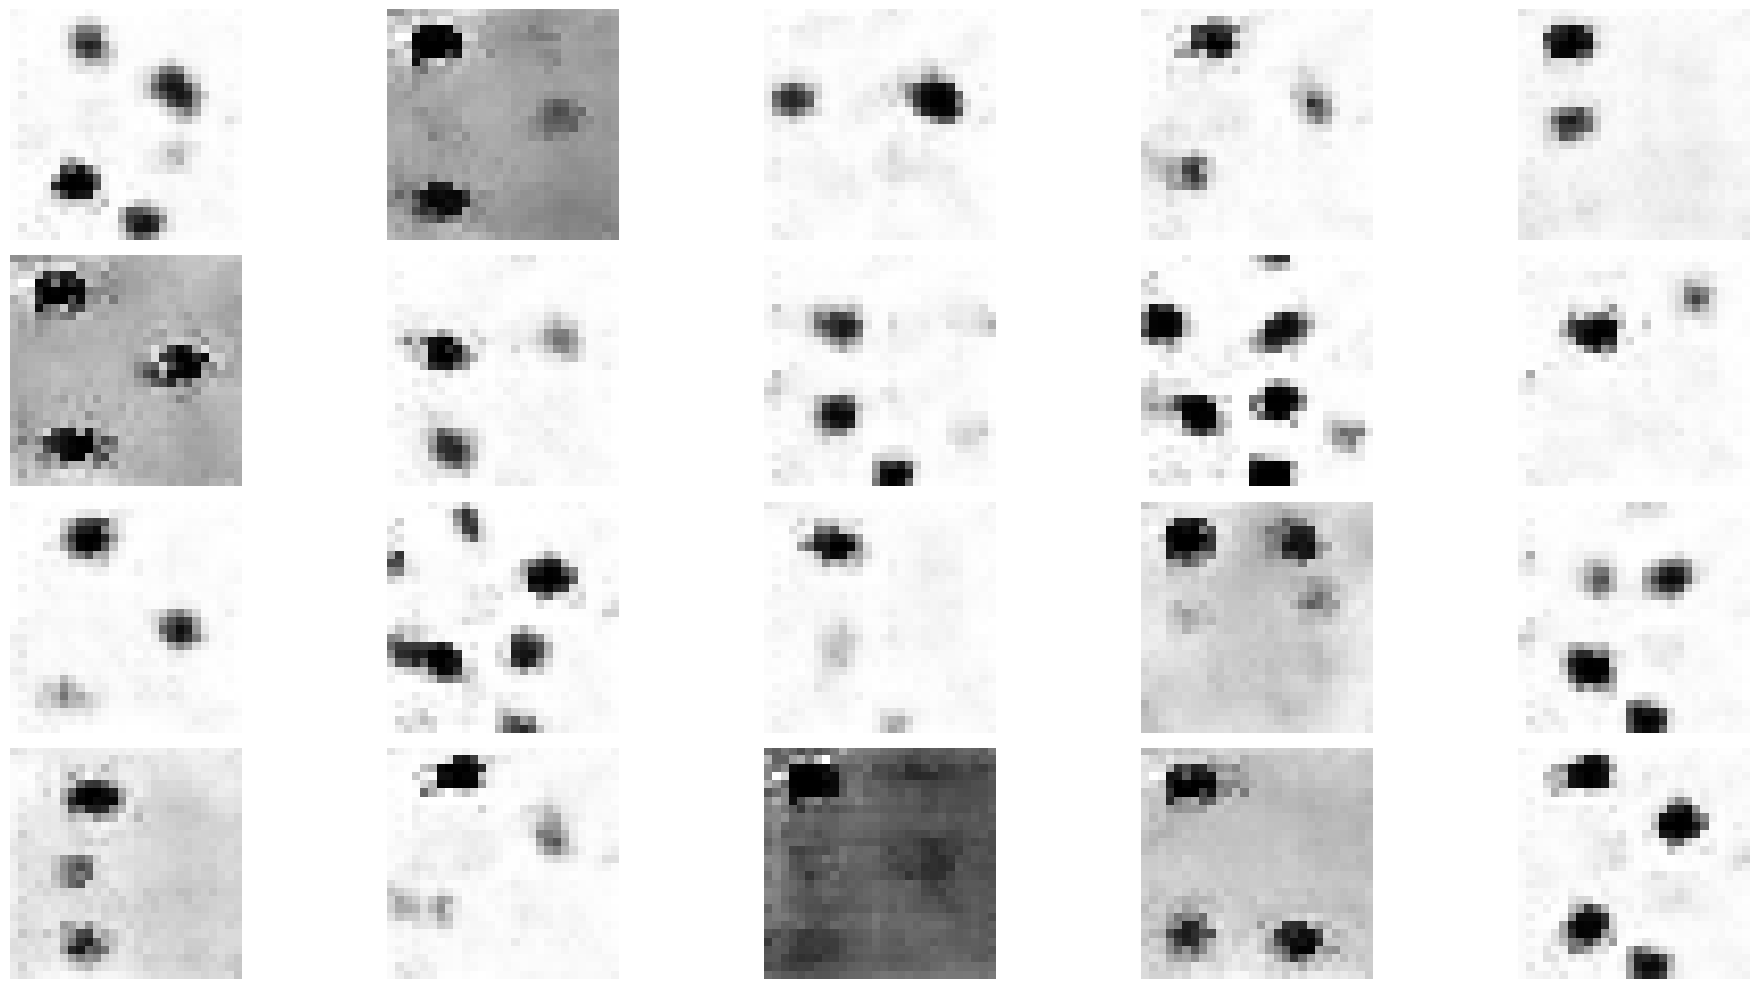

In [15]:

noise = tf.random.normal([20, latent_dim])
generated_images = generator.predict(noise)

plt.figure(figsize=(20, 10))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 5, i+1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

## encourage me
Don't forget to **upvote** if you like this, and don't forget to give me **your opinion** about this work and the other works I published previously.